<a href="https://colab.research.google.com/github/d4vidi4n/EL4106/blob/main/SVM_Proy_IC_JE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preámbulo

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as sp
import matplotlib.pyplot as plt
import time
import os
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report

from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as sp
import gc

# 1) Lectura de datos

In [ ]:
from google.colab import files
uploaded = files.upload()  # sensorless_tarea3_train.txt
!ls

Saving df_test_no_labels.csv to df_test_no_labels.csv
Saving df_trainval.csv to df_trainval.csv
df_test_no_labels.csv  df_trainval.csv	figures  sample_data


In [ ]:
df_trainval = pd.read_csv('df_trainval.csv')
df_test_no_labels = pd.read_csv('df_test_no_labels.csv')
df_trainval
# df_test_no_labels

R1_0      R1_1      R1_2      R1_3      R1_4      R1_5      R1_6  \
0     12.73430  12.73430  12.73420  12.73420  12.73550  12.73560  12.73700   
1     11.51190  11.52490  11.53670  11.54820  11.55860  11.56800  11.57650   
2     10.85570  10.85860  10.86130  10.86350  10.86440  10.86490  10.86450   
3     12.55170  12.55180  12.55190  12.55190  12.55200  12.55200  12.55210   
4      8.78442   8.77909   8.77488   8.77016   8.76573   8.76157   8.75735   
...        ...       ...       ...       ...       ...       ...       ...   
8791  12.39290  12.39290  12.39260  12.39240  12.39260  12.39240  12.39240   
8792  12.83420  12.83410  12.83410  12.83410  12.83410  12.83410  12.83410   
8793  11.99420  11.99420  11.99400  11.99400  11.99380  11.99390  11.99390   
8794  12.94500  12.94540  12.94560  12.94460  12.94370  12.94260  12.94080   
8795  12.22490  12.22540  12.22590  12.22630  12.22670  12.22680  12.22710   

          R1_7      R1_8      R1_9  ...  Humidity_119  Humidity_120  \
0     12.73740  12.73710  12.73700  ...       60.0959       60.1002   
1     11.58420  11.59120  11.59770  ...       64.9539       64.9585   
2     10.86390  10.86280  10.86110  ...       56.4906       56.4957   
3     12.55210  12.55220  12.55220  ...       64.5927       64.5912   
4      8.75307   8.74919   8.74538  ...       58.2097       58.2229   
...        ...       ...       ...  ...           ...           ...   
8791  12.39290  12.39280  12.39260  ...       49.8931       49.8782   
8792  12.83410  12.83410  12.83410  ...       53.2695       53.2648   
8793  11.99350  11.99360  11.99370  ...       67.2733       67.2698   
8794  12.94000  12.93950  12.93910  ...       52.3949       52.3953   
8795  12.22740  12.22720  12.22750  ...       56.7664       56.7630   

      Humidity_121  Humidity_122  Humidity_123  Humidity_124  Humidity_125  \
0          60.1041       60.1076       60.1108       60.1137       60.1163   
1          64.9626       64.9663       64.9684       64.9687       64.9689   
2          56.5004       56.5045       56.5083       56.5118       56.5149   
3          64.5898       64.5886       64.5875       64.5865       64.5855   
4          58.2348       58.2456       58.2553       58.2642       58.2722   
...            ...           ...           ...           ...           ...   
8791       49.8613       49.8459       49.8321       49.8195       49.8082   
8792       53.2605       53.2592       53.2585       53.2578       53.2572   
8793       67.2665       67.2636       67.3011       67.3350       67.3656   
8794       52.3956       52.3960       52.3963       52.3965       52.3968   
8795       56.7600       56.7573       56.7548       56.7526       56.7506   

      Humidity_126  Humidity_127  class  
0          60.1187       60.1208      1  
1          64.9691       64.9693      1  
2          56.5151       56.5149      1  
3          64.5847       64.5839      1  
4          58.2794       58.2948      1  
...            ...           ...    ...  
8791       49.7979       49.7878      3  
8792       53.2567       53.2562      3  
8793       67.3934       67.4185      3  
8794       52.3970       52.3989      3  
8795       56.7487       56.7471      3  

[8796 rows x 1153 columns]

# 2) Gráfico de algunas señales

Puede ser buena idea graficar una cierta cantidad de datos aleatorios que esten cerca, en grupos de la misma clase de esta manera se pueden ver ciertas correlaciones visuales entre las señales y la clase.

El R_6 puede que esté bastante relacionado con la clase ya que se aprecian lineas rectas separadas por la clase, las de clase 1 quedan abajo mientras que las de clase 2 al medio y las otras de clase 3 tienden a quedar arriba. Aunque igual se aprecia cierta confusión entre las clases 2 y 3. Se aprecia claramente en varias señales con varios sensores que las señales de clase 1 quedan abajo.

Analizando la humedad, no se aprecia ni una correlación, lo que sugiere que probablemente esta característica no es representativo del estímulo.

Puede no ser necesario aplicar un filtro ya que algraficar varias señales, se ven lineas rectas apiladas, donde a priori se conclute que el filtrado realmente no ayudaría a distinguir las líneas porque estas ya se distinguen de esta forma.

Vuelvo a reiterar, es probable que las clases 2 y 3 se confundan al momento de clasificar ya que las líneas se tienden a apilar y casi siempre las de clase 1 quedan abajo y las señales de las otras clases otras a veces se superponen.

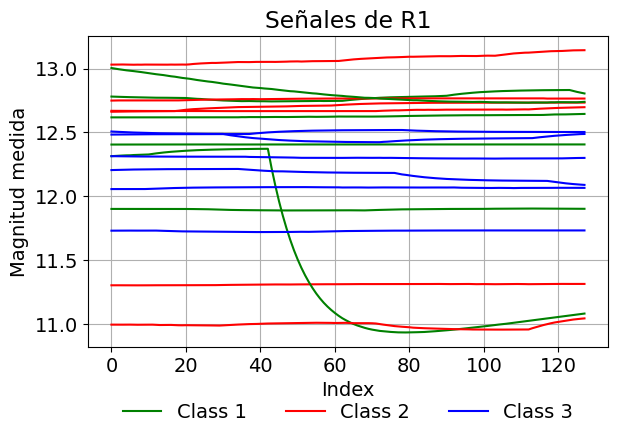

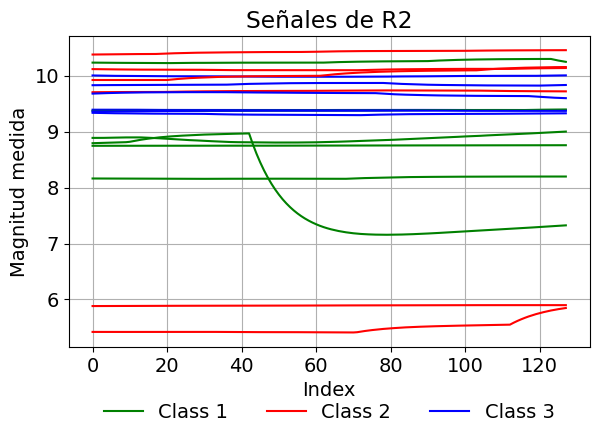

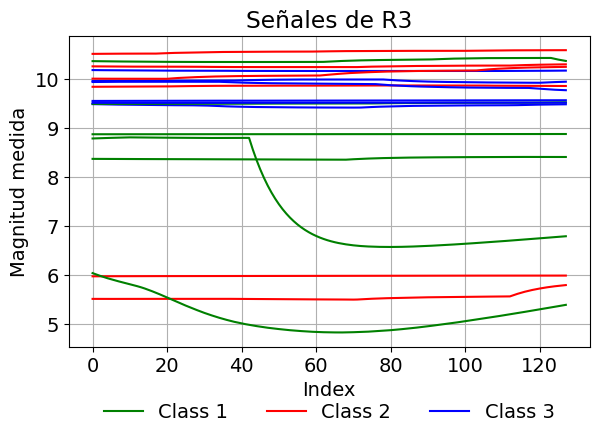

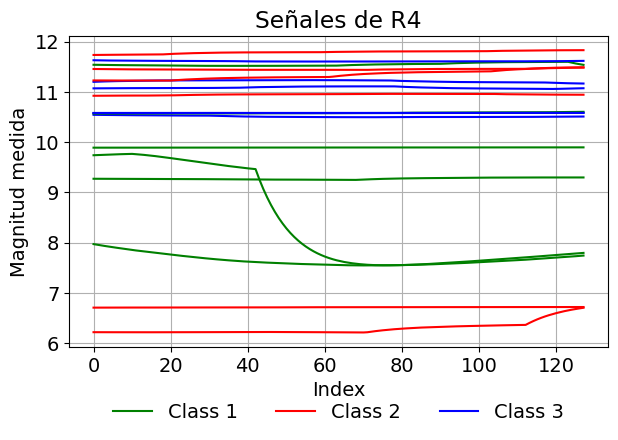

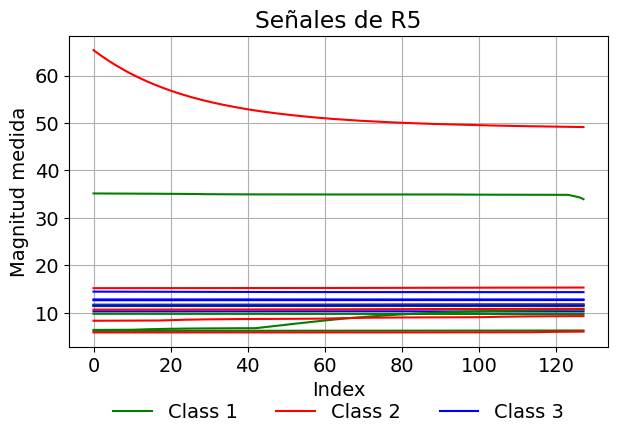

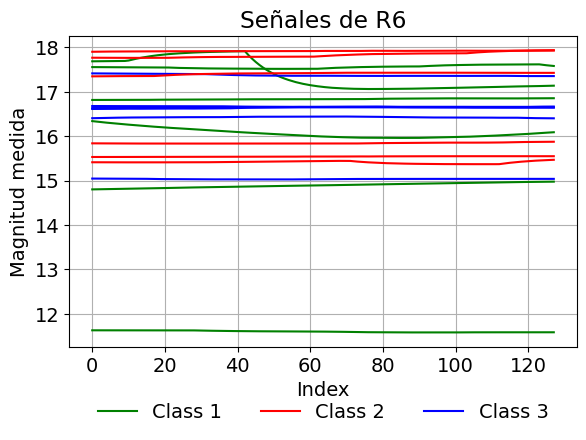

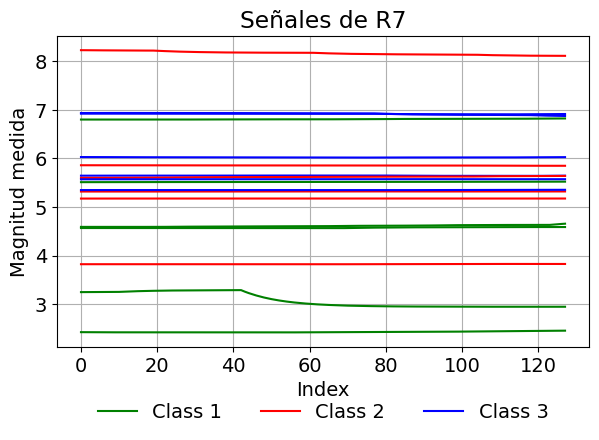

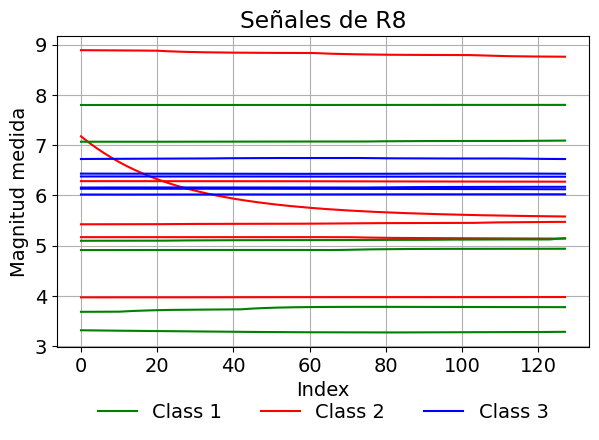

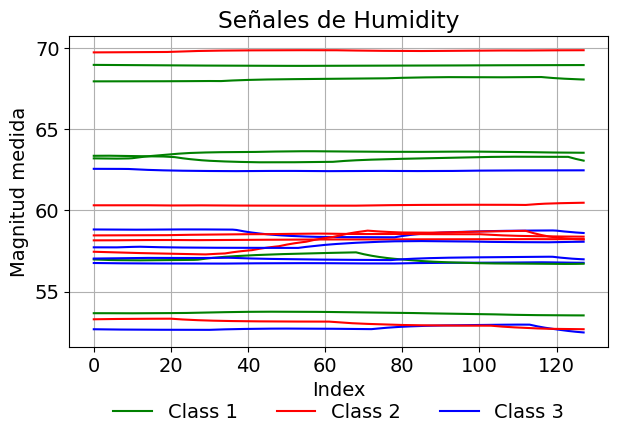

In [ ]:
num_sign_per_graph = 6
rs = 20
folder = '/content/SVM/graficos_prelim/' # Ruta para guardar los gráficos, variable global en este punto
os.makedirs(folder, exist_ok=True)

# Definición única de parámetros gráficos
plot_kwargs_1 = {'color': 'green','label': 'Class 1'}
plot_kwargs_2 = {'color': 'red', 'label': 'Class 2'}
plot_kwargs_3 = {'color': 'blue', 'label': 'Class 3'}
plt.rcParams.update({'font.size': 14})  # Cambia el número según el tamaño deseado

for start in range(9):
  idx = [start*128, start*128 + 128]

  plt.figure()
  plt.grid()
  plt.xlabel('Index')
  plt.ylabel('Magnitud medida')

  plt.title(f'Señales de {df_trainval.iloc[:, idx[0]:idx[1]].keys()[0][:-2]}')

  for i in range(num_sign_per_graph):
    plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_1)
    plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_2)
    plt.plot(np.arange(0,128), df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]], **plot_kwargs_3)
    if i == 0:
      plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
      plt.tight_layout()  # Ajusta el layout para que no se corte nada

  filename = f'signals_{df_trainval.iloc[:, idx[0]:idx[1]].keys()[0][:-2]}.pdf'

  filepath = os.path.join(folder, filename)
  plt.savefig(filepath)
  plt.show()

import zipfile
import glob

with zipfile.ZipFile("/content/SVM/graficos_prelim.zip", "w") as zipf:
    for file in glob.glob('/content/SVM/graficos_prelim/*.pdf'):
        zipf.write(file, arcname=file.split("/")[-1])

No se aprecian oscilaciones de ni un tipo, por lo que no se hará un análisis en frecuencia

# 3) Eliminar señales o no

Código para eliminar todos los archivos de una carpeta

In [65]:
def delete_all_files(carpeta):
  for filename in os.listdir(carpeta):
      file_path = os.path.join(carpeta, filename)
      if os.path.isfile(file_path):
          os.remove(file_path)

Código para demostrar que no hay componentes oscilatorias relevantes en relación a la media

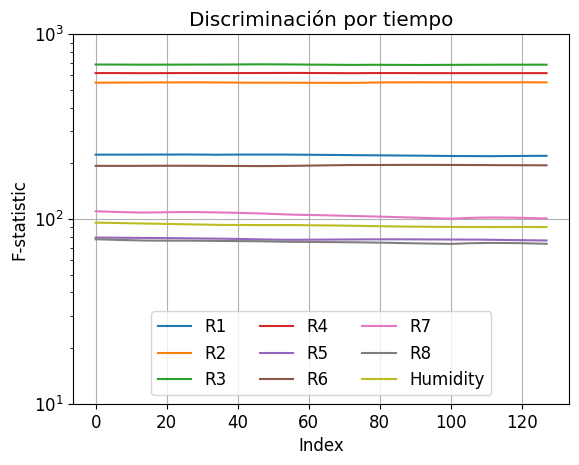

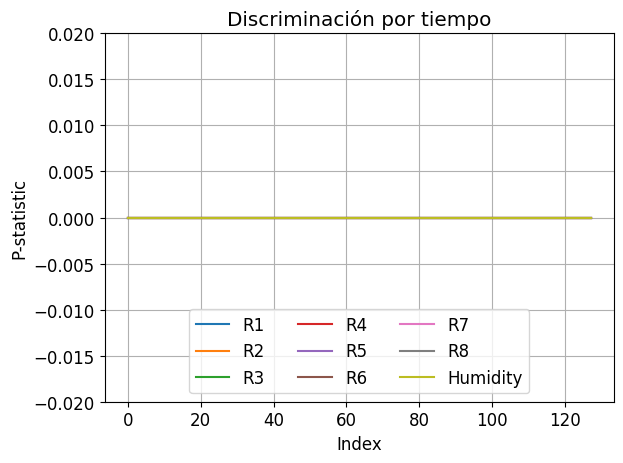

In [76]:
folder = '/content/delete_signals/graficos_ANOVA/'  # Carpeta para guardar los gráficos FFT
os.makedirs(folder, exist_ok=True)
delete_all_files(folder)

plt.rcParams.update({'font.size': 12})  # Cambia el número según el tamaño deseado

plt.figure(1)
fig1 = plt.gcf()

plt.figure(2)
fig2 = plt.gcf()

for start in range(9):
    idx = [start * 128, start * 128 + 128]
    f_values, p_values = f_classif(df_trainval.iloc[:, idx[0]:idx[1]], df_trainval['class'])
    label = df_trainval.iloc[:, idx[0]:idx[1]].keys()[0][:-2]

    # Primer gráfico (por ejemplo, con marker)
    plt.figure(fig1.number)
    plt.plot(f_values, label=label)
    plt.ylim(10, 1000)
    plt.yscale('log')
    plt.xlabel('Index')
    plt.ylabel("F-statistic")
    plt.title("Discriminación por tiempo")
    plt.grid(True)
    plt.legend(loc='lower center', ncol=3, frameon=True)

    # Segundo gráfico (igual o diferente estilo)
    plt.figure(fig2.number)
    plt.plot(p_values, label=label)
    plt.xlabel('Index')
    plt.ylabel("P-statistic")
    plt.title("Discriminación por tiempo")
    plt.grid(True)
    plt.legend()
    plt.ylim(-0.02, 0.02)
    plt.legend(loc='lower center', ncol=3, frameon=True)

plt.tight_layout()
fig1.savefig(os.path.join(folder, 'f_stat.pdf'))
fig2.savefig(os.path.join(folder, 'p_stat.pdf'))
plt.show()

# 4) Filtrado de la señal
No pq no hay ruido ni componentes periodicas que pudieran requerir la extracción de carcaterísticas frecuenciales

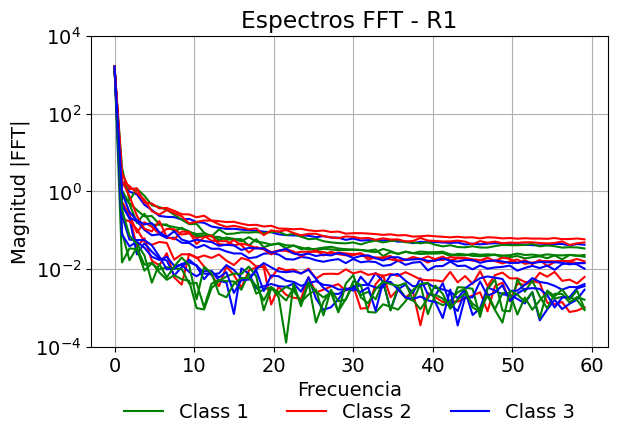

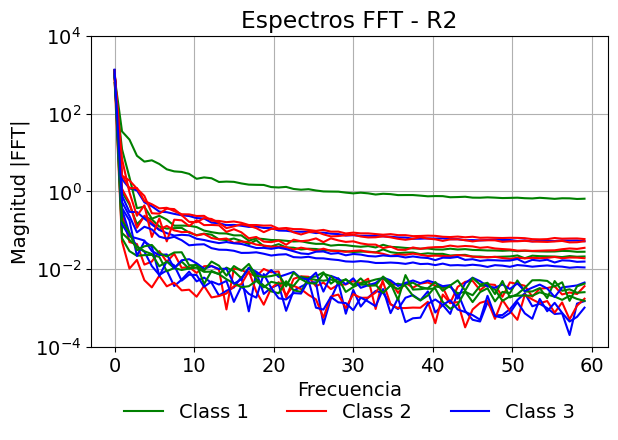

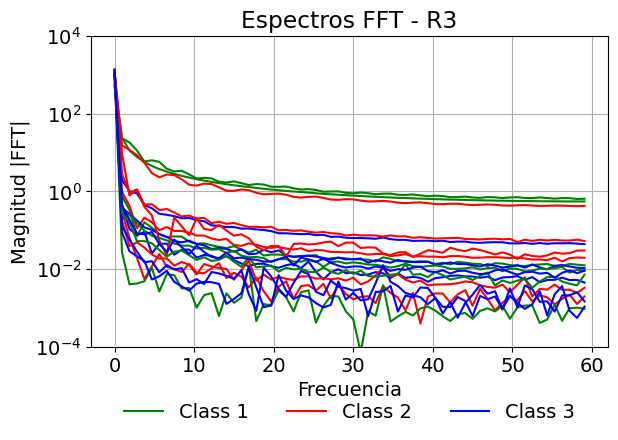

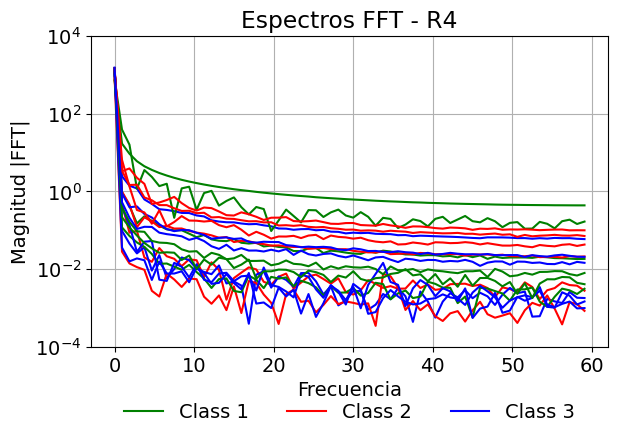

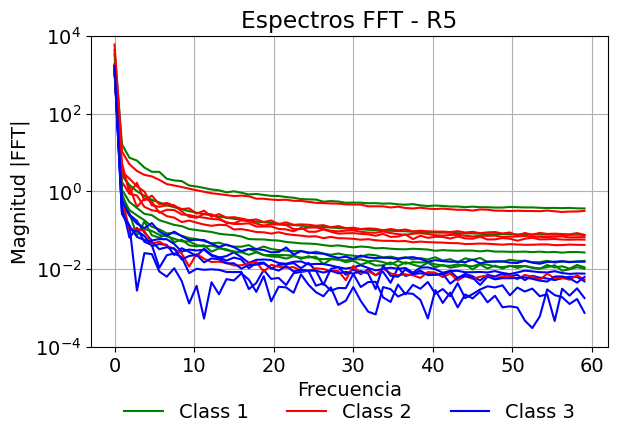

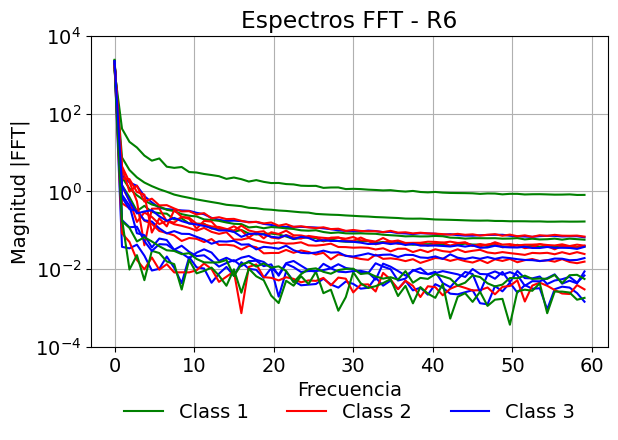

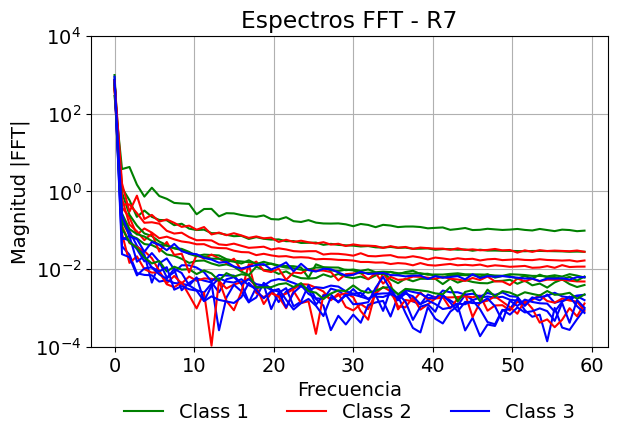

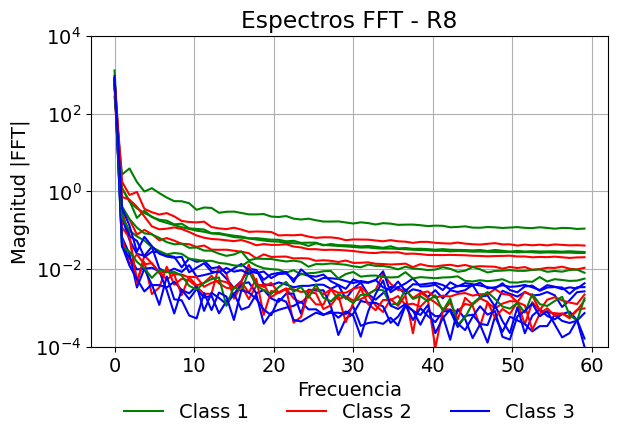

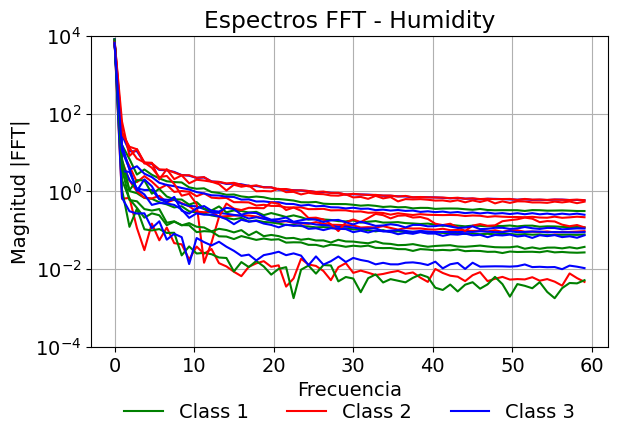

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import os

num_sign_per_graph = 6
rs = 42
folder = '/content/filter/graficos_fft/'  # Carpeta para guardar los gráficos FFT
os.makedirs(folder, exist_ok=True)

# Definición de estilo por clase
plot_kwargs_1 = {'color': 'green','label': 'Class 1'}
plot_kwargs_2 = {'color': 'red', 'label': 'Class 2'}
plot_kwargs_3 = {'color': 'blue', 'label': 'Class 3'}
plt.rcParams.update({'font.size': 14})

# Número de puntos por señal
N = 128
# Frecuencia de muestreo (puedes ajustar si tienes el valor real)
fs = 120

freqs = np.fft.fftfreq(N, d=1/fs)[:N//2]

for start in range(9):
    idx = [start*128, start*128 + 128]

    plt.figure()
    plt.grid()
    plt.xlabel('Frecuencia')
    plt.ylabel('Magnitud |FFT|')
    plt.title(f'Espectros FFT - {df_trainval.iloc[:, idx[0]:idx[1]].columns[0][:-2]}')
    plt.ylim(10**-4 , 10**4)

    for i in range(num_sign_per_graph):
        for class_id, plot_kwargs in zip([1, 2, 3], [plot_kwargs_1, plot_kwargs_2, plot_kwargs_3]):
            signal = df_trainval[df_trainval['class'] == class_id].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]].values # signal = signal - np.mean(signal)
            fft_vals = np.fft.fft(signal)
            magnitude = np.abs(fft_vals[:N//2])
            plt.plot(freqs, magnitude, **plot_kwargs)
            plt.yscale('log')

        if i == 0:
            plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
            plt.tight_layout()

    filename = f'fft_{df_trainval.iloc[:, idx[0]:idx[1]].columns[0][:-2]}.pdf'
    filepath = os.path.join(folder, filename)
    plt.savefig(filepath)
    plt.show()


# 5) Definición de las características

Vector de cálculo de características (Media, Varianza, etc) ()

In [165]:
from statsmodels.tsa.ar_model import AutoReg

def get_single_ar_coeff(signal, order=3, method='mean'):
    try:
        model = AutoReg(signal, lags=order, old_names=False)
        result = model.fit()
        coeffs = result.params[1:]  # Ignorar el intercepto
        if method == 'mean':
            return np.mean(coeffs)
        elif method == 'norm':
            return np.linalg.norm(coeffs)
        elif method == 'first':
            return coeffs[0]
        elif method == 'max_abs':
            return coeffs[np.argmax(np.abs(coeffs))]
        else:
            return np.nan
    except:
        return np.nan

In [164]:
def extract_features(signal):
  STD_THRESHOLD = 1e-12

  is_constant = np.std(signal) < STD_THRESHOLD
  # is_constant = np.std(signal) == 0
  is_too_short = len(signal) < 2

  return {
      'mean': np.mean(signal),
      'var': np.var(signal),
      'mad': np.median(np.abs(signal - np.median(signal))),
      'max': np.max(signal),
      'min': np.min(signal),
      'ran': np.max(signal) - np.min(signal),
      'sma': np.sum(np.abs(signal)),
      'enrgy': np.sum(signal**2) / len(signal),
      'iqr': sp.iqr(signal),
      'entpy': sp.entropy(signal),
      'arCoeff': get_single_ar_coeff(signal),  # Placeholder; lo puedes reemplazar cuando tengas la función
      'corr': 0.0 if is_constant or is_too_short else np.corrcoef(signal[:-1], signal[1:])[0, 1]
  }

def calculation_feature_vector(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    # for idx, row in df_data[8215:8220].iterrows():
    # for idx, row in df_data[8216:8217].iterrows(): #Dato problemático -> df_data.iloc[8216]
    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features(signal)
            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

Hay un caso de un sample que da un valor muy bajo en la varianza, esto genra una división por cero, por esta razón de establecerá una forma de lidiar con este caso y evitar que haya un NaN

#### Cálculo del vector de cracterísticas

In [166]:
train_val_data = calculation_feature_vector(df_trainval)
df_test_data = calculation_feature_vector(df_test_no_labels)

En la celda a continuación se definen los conjuntos que se utilizarán para entrenar los modelo y los subconjuntos del conjunto de validación para cuando busque los mejore hiperparámetros de la red neuronal

In [167]:
df_train, df_val = train_test_split(train_val_data, test_size=0.3, random_state=10, stratify=train_val_data['class'])

df_test = df_test_data.copy()

Normalización y separación del vector de cracaterísticas y la clase de los datos

In [168]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train.iloc[:,0:-1])

df_train.iloc[:,0:-1] = scaler.transform(df_train.iloc[:,0:-1])
df_val.iloc[:,0:-1] = scaler.transform(df_val.iloc[:,0:-1])
df_test.iloc[:,0:] = scaler.transform(df_test_data.iloc[:,0:])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

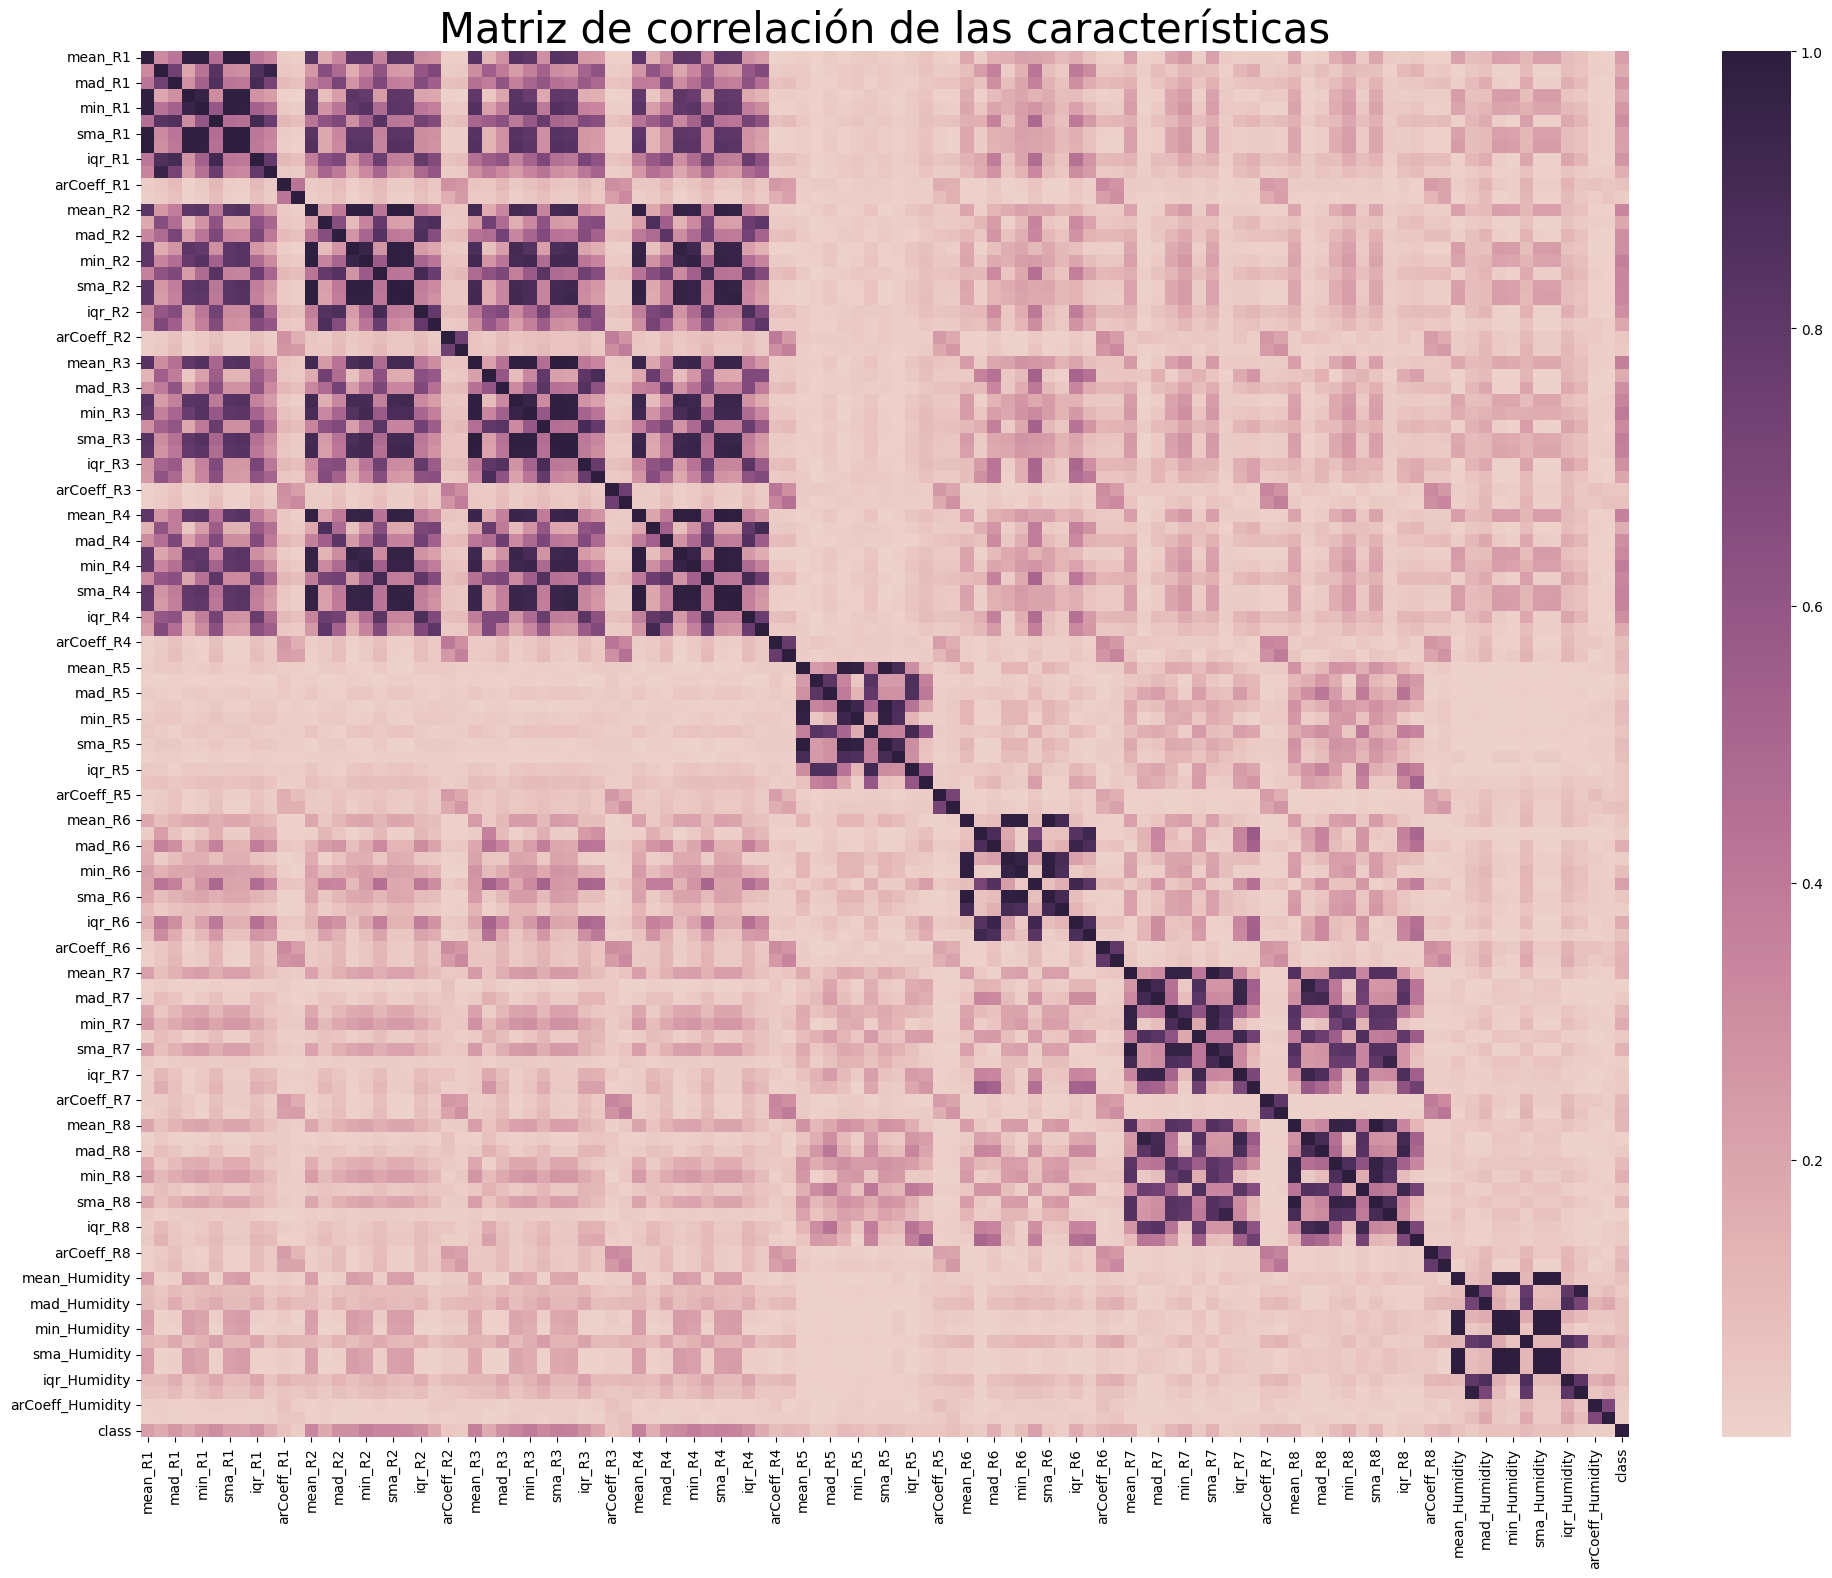

In [169]:
plt.figure(figsize=(24, 18))
correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=30)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

# 7) a) Clasificador SVM

Permutación predefinida para la validación del modelo

In [170]:
def predefined_split(class_val):
  n_samples = len(class_val)                                    # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
  n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
  n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

  np.random.seed(42)
  indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
  test_fold = np.full(n_samples, -1)                            # Se define el arreglo de los índices de elemntos de train y test

  # Asignar 1 a los índices que serán test
  test_indices = indices[:n_val_grid_search]
  test_fold[test_indices] = 1

  ps = PredefinedSplit(test_fold)

  return ps

Cálculo de la proporción de observaciones de cada clase en los subconjuntos de test par ala búsqueda de hiperparámetros

In [171]:
# Permutación predefinida para la validación del modelo con el conjunto completo de cracaterísticas
ps = predefined_split(y_val)

test_fold = ps.test_fold
y_val_array = np.array(y_val)

# Índices a partir de la permutación predefinida
train_indices = np.where(test_fold == -1)[0]
val_indices = np.where(test_fold == 1)[0]

# Obtener subconjuntos de clases
y_val_train_subset = y_val_array[train_indices]
y_val_val_subset = y_val_array[val_indices]

# Calcular proporciones
train_class_dist = pd.Series(y_val_train_subset).value_counts(normalize=True).sort_index()
val_class_dist = pd.Series(y_val_val_subset).value_counts(normalize=True).sort_index()

# Mostrar proporciones
print("Distribución de clases en el subset de entrenamiento (dentro de validación):")
print(train_class_dist)

print("\nDistribución de clases en el subset de validación (dentro de validación):")
print(val_class_dist)


Distribución de clases en el subset de entrenamiento (dentro de validación):
1.0    0.329182
2.0    0.343801
3.0    0.327017
Name: proportion, dtype: float64

Distribución de clases en el subset de validación (dentro de validación):
1.0    0.342172
2.0    0.309343
3.0    0.348485
Name: proportion, dtype: float64


Función para gejecutar la clasificación dado los hiperparámetros de un SVM y los conjuntos de entrenamiento y validación

In [172]:
def make_clf(svc, params_svc, df_t, y_t, df_v, y_v):

  clf = GridSearchCV(svc, params_svc, cv=ps) #ps es una variable global, no se coloca como entrada para reducir al máximo las entradas de la función y hacer menos confusa las iteraciones

  # GridSearch
  t0 = time.time()
  clf.fit(df_v, y_v)
  t = time.time()
  tiempo_svm_lin_grid_search = t - t0
  print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

  display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

  best_clf = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()

  # Entrenamiento del SVM lineal con el conjunto de entrenamiento
  t0 = time.time()
  best_clf.fit(df_t, y_t)
  t = time.time()
  tiempo_svm_lin_training = t - t0
  print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

  print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)

  return best_clf

Función para determinar la matriz de confusión dado un SVM y los conjuntos de validación y predicción de la validación

In [173]:
def conf_mat(bst_clf, y_v, y_pr):

  plt.rcParams['font.size'] = 10.0

  gamma_val = round(bst_clf.gamma, 3) if isinstance(bst_clf.gamma, float) else bst_clf.gamma

  accu_score = accuracy_score(y_v, y_pr)

  disp = ConfusionMatrixDisplay(np.round(confusion_matrix(y_v, y_pr, normalize='true'), decimals=6))#, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), xticklabels=[1, 2, 3],yticklabels=[1, 2, 3])
  disp.plot(cmap='RdPu')

  if best_model.kernel == 'poly':
    plt.title(f'C={bst_clf.C}, coef0={bst_clf.coef0}, deg={bst_clf.degree}, gamma={gamma_val}\nAccuracy = {accu_score:.4f}', fontsize = 10)
    filename = f'mat_conf_kernel-{bst_clf.kernel}_C-{bst_clf.C}_deg-{bst_clf.degree}_gamma-{gamma_val}.svg'
  else:
    plt.title(f'C={bst_clf.C}, gamma={gamma_val}\nAccuracy = {accu_score:.4f}', fontsize = 10)
    filename = f'mat_conf_kernel-{bst_clf.kernel}_C-{bst_clf.C}_gamma-{gamma_val}.svg'

  plt.suptitle(f'Matriz de confusión normalizada SVM, kernel {bst_clf.kernel}', x=0.43, y=1.00)

  filepath = os.path.join(folder, filename)

  os.makedirs(folder, exist_ok=True)

  plt.savefig(filepath)

  plt.show()

### Grid search para encontrar el mejor kernel, con todas las características


In [230]:
n_features = df_val.shape[1]
gamma_default = 1 / (n_features * df_val.var().mean()) #gamma predefinido para todo el dataset

#### Encontrar el mejor kernel

Tiempo GridSearch SVM lineal:  58.198452949523926


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.219494           0.0         0.068907             0.0     0.01   
1        0.320696           0.0         0.084112             0.0     0.01   
2        0.403562           0.0         0.172352             0.0     0.01   
3        0.482584           0.0         0.136292             0.0     0.01   
4        0.256058           0.0         0.059665             0.0     0.10   
5        0.288328           0.0         0.084214             0.0     0.10   
6        0.332905           0.0         0.151356             0.0     0.10   
7        0.396482           0.0         0.122842             0.0     0.10   
8        0.672897           0.0         0.052407             0.0     1.00   
9        0.273531           0.0         0.076179             0.0     1.00   
10       0.273613           0.0         0.125142             0.0     1.00   
11       0.292336           0.0         0.096604             0.0     1.00   
12       5.116889           0.0         0.072940             0.0    10.00   
13       0.433162           0.0         0.100999             0.0    10.00   
14       0.381016           0.0         0.194592             0.0    10.00   
15       0.282549           0.0         0.088571             0.0    10.00   
16      44.400161           0.0         0.047374             0.0   100.00   
17       0.313210           0.0         0.076354             0.0   100.00   
18       0.309611           0.0         0.103994             0.0   100.00   
19       0.224850           0.0         0.075614             0.0   100.00   

   param_kernel                            params  split0_test_score  \
0        linear   {'C': 0.01, 'kernel': 'linear'}           0.670455   
1          poly     {'C': 0.01, 'kernel': 'poly'}           0.368687   
2           rbf      {'C': 0.01, 'kernel': 'rbf'}           0.416667   
3       sigmoid  {'C': 0.01, 'kernel': 'sigmoid'}           0.535354   
4        linear    {'C': 0.1, 'kernel': 'linear'}           0.689394   
5          poly      {'C': 0.1, 'kernel': 'poly'}           0.459596   
6           rbf       {'C': 0.1, 'kernel': 'rbf'}           0.654040   
7       sigmoid   {'C': 0.1, 'kernel': 'sigmoid'}           0.597222   
8        linear      {'C': 1, 'kernel': 'linear'}           0.707071   
9          poly        {'C': 1, 'kernel': 'poly'}           0.574495   
10          rbf         {'C': 1, 'kernel': 'rbf'}           0.714646   
11      sigmoid     {'C': 1, 'kernel': 'sigmoid'}           0.521465   
12       linear     {'C': 10, 'kernel': 'linear'}           0.718434   
13         poly       {'C': 10, 'kernel': 'poly'}           0.635101   
14          rbf        {'C': 10, 'kernel': 'rbf'}           0.744949   
15      sigmoid    {'C': 10, 'kernel': 'sigmoid'}           0.482323   
16       linear    {'C': 100, 'kernel': 'linear'}           0.739899   
17         poly      {'C': 100, 'kernel': 'poly'}           0.686869   
18          rbf       {'C': 100, 'kernel': 'rbf'}           0.726010   
19      sigmoid   {'C': 100, 'kernel': 'sigmoid'}           0.470960   

    mean_test_score  std_test_score  rank_test_score  
0          0.670455             0.0                9  
1          0.368687             0.0               20  
2          0.416667             0.0               19  
3          0.535354             0.0               14  
4          0.689394             0.0                7  
5          0.459596             0.0               18  
6          0.654040             0.0               10  
7          0.597222             0.0               12  
8          0.707071             0.0                6  
9          0.574495             0.0               13  
10         0.714646             0.0                5  
11         0.521465             0.0               15  
12         0.718434             0.0                4  
13         0.635101             0.0               11  
14         0.744949             0.0             

Tiempo entrenamiento SVM lineal:  2.5452187061309814
Tiempo GridSearch + Entrenamiento = 60.74367165565491


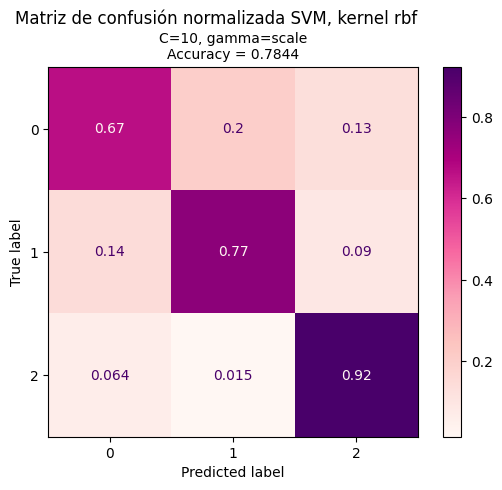

In [175]:
params = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
svc = svm.SVC()
best_model_kernel = make_clf(svc, params, df_train, y_train, df_val, y_val) # Todas las características

y_pred = best_model_kernel.predict(df_val) # Predicción del conjunto de validación

folder = '/content/SVM/train/full_dataset/Grid_Search_best_kernel/'

conf_mat(best_model_kernel, y_val, y_pred)

#### Encontrar el mejor RBF
Al encontrar el mejor kernel, este fue el rbf y debido a que el mejor valor de C fue 10 (cerca del máximo valor dado en el Grid Search), se pueban mayores valores de C.


Tiempo GridSearch SVM lineal:  15.41663932800293


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.531465           0.0         0.244719             0.0        1   
1        0.311907           0.0         0.142122             0.0        1   
2        0.275286           0.0         0.127968             0.0        1   
3        0.320407           0.0         0.143277             0.0        1   
4        0.451975           0.0         0.172790             0.0        1   
5        0.317108           0.0         0.143980             0.0       10   
6        0.271127           0.0         0.130120             0.0       10   
7        0.251925           0.0         0.116688             0.0       10   
8        0.394465           0.0         0.148855             0.0       10   
9        0.441000           0.0         0.173538             0.0       10   
10       0.270030           0.0         0.125370             0.0      100   
11       0.286478           0.0         0.109346             0.0      100   
12       0.324607           0.0         0.108617             0.0      100   
13       0.416894           0.0         0.139159             0.0      100   
14       0.435560           0.0         0.172146             0.0      100   
15       0.333672           0.0         0.118014             0.0     1000   
16       0.516469           0.0         0.100899             0.0     1000   
17       0.622769           0.0         0.093007             0.0     1000   
18       0.430304           0.0         0.138472             0.0     1000   
19       0.438836           0.0         0.173744             0.0     1000   
20       0.484841           0.0         0.182962             0.0     2000   
21       1.153635           0.0         0.166267             0.0     2000   
22       1.175162           0.0         0.093675             0.0     2000   
23       0.423902           0.0         0.136865             0.0     2000   
24       0.432391           0.0         0.174940             0.0     2000   

    param_gamma                                       params  \
0      0.000089     {'C': 1, 'gamma': 8.857553769927608e-05}   
1      0.000886     {'C': 1, 'gamma': 0.0008857553769927609}   
2      0.008858      {'C': 1, 'gamma': 0.008857553769927608}   
3      0.088576       {'C': 1, 'gamma': 0.08857553769927609}   
4      0.885755        {'C': 1, 'gamma': 0.8857553769927609}   
5      0.000089    {'C': 10, 'gamma': 8.857553769927608e-05}   
6      0.000886    {'C': 10, 'gamma': 0.0008857553769927609}   
7      0.008858     {'C': 10, 'gamma': 0.008857553769927608}   
8      0.088576      {'C': 10, 'gamma': 0.08857553769927609}   
9      0.885755       {'C': 10, 'gamma': 0.8857553769927609}   
10     0.000089   {'C': 100, 'gamma': 8.857553769927608e-05}   
11     0.000886   {'C': 100, 'gamma': 0.0008857553769927609}   
12     0.008858    {'C': 100, 'gamma': 0.008857553769927608}   
13     0.088576     {'C': 100, 'gamma': 0.08857553769927609}   
14     0.885755      {'C': 100, 'gamma': 0.8857553769927609}   
15     0.000089  {'C': 1000, 'gamma': 8.857553769927608e-05}   
16     0.000886  {'C': 1000, 'gamma': 0.0008857553769927609}   
17     0.008858   {'C': 1000, 'gamma': 0.008857553769927608}   
18     0.088576    {'C': 1000, 'gamma': 0.08857553769927609}   
19     0.885755     {'C': 1000, 'gamma': 0.8857553769927609}   
20     0.000089  {'C': 2000, 'gamma': 8.857553769927608e-05}   
21     0.000886  {'C': 2000, 'gamma': 0.0008857553769927609}   
22     0.008858   {'C': 2000, 'gamma': 0.008857553769927608}   
23     0.088576    {'C': 2000, 'gamma': 0.08857553769927609}   
24     0.885755     {'C': 2000, 'gamma': 0.8857553769927609}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.539141         0.539141             0.0               25  
1            0.652778         0.652778             0.0               19  
2            0.715909         0.715909             0.0                6  
3            0.704545         0.704545  

Tiempo entrenamiento SVM lineal:  2.428525924682617
Tiempo GridSearch + Entrenamiento = 17.845165252685547


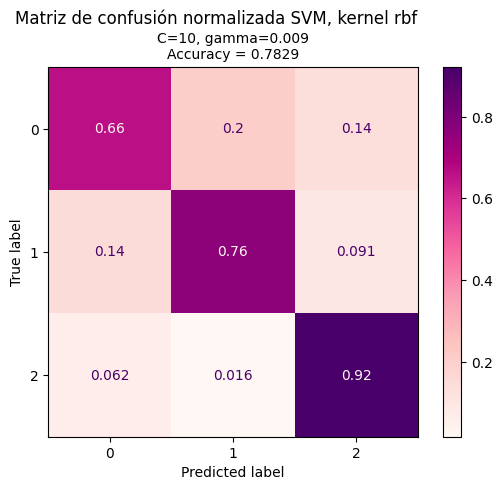

In [176]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model_rbf_all_feat = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model_rbf_all_feat.predict(df_val) # Predicción del conjunto de validación
folder = '/content/SVM/train/full_dataset/Grid_Search_best_rbf/'
conf_mat(best_model_rbf_all_feat, y_val, y_pred)

#### Encontrar el mejor lineal
Aqui el mejor C fue de 10, por lo tanto se establece un rango que incluya este valor y algunos más altos


Tiempo GridSearch SVM lineal:  13.62514615058899


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       0.673343           0.0         0.052650             0.0        1   
1       0.994144           0.0         0.054597             0.0        2   
2       2.149007           0.0         0.052062             0.0        5   
3       5.683658           0.0         0.048482             0.0       10   

      params  split0_test_score  mean_test_score  std_test_score  \
0   {'C': 1}           0.707071         0.707071             0.0   
1   {'C': 2}           0.707071         0.707071             0.0   
2   {'C': 5}           0.719697         0.719697             0.0   
3  {'C': 10}           0.718434         0.718434             0.0   

   rank_test_score  
0                3  
1                3  
2                1  
3                2

Tiempo entrenamiento SVM lineal:  21.519157648086548
Tiempo GridSearch + Entrenamiento = 35.14430379867554


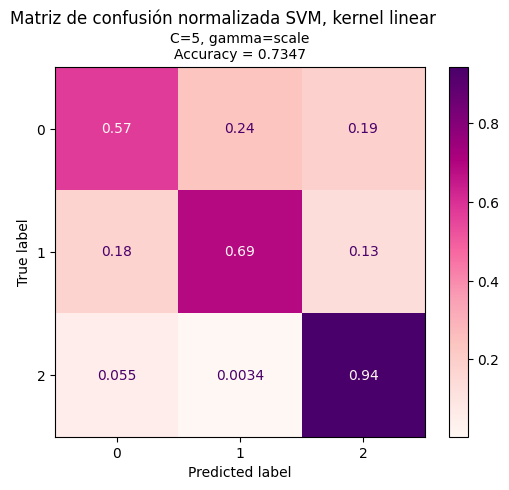

In [177]:
# parameters = {'C':[1, 10, 100, 200, 500]} #Estos valores tan altos hacen que el modelo se tarde demasiado en entrenar
parameters = {'C':[1, 2, 5, 10]}
svc = svm.SVC(kernel='linear')
best_model_lin_all_feat = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model_lin_all_feat.predict(df_val) # Predicción del conjunto de validación
folder = '/content/SVM/train/full_dataset/Grid_Search_best_lin/'
conf_mat(best_model_lin_all_feat, y_val, y_pred)

#### Encontrar el mejor poly
Se decidió probar ya que el kernel rbf no dió buenos resultados, no mejoró con respecto al resultado de la búsqueda del mejor grid search


Tiempo GridSearch SVM lineal:  21.434197425842285


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.220382           0.0         0.060861             0.0        1   
1        0.227675           0.0         0.057270             0.0        1   
2        0.236327           0.0         0.055677             0.0        1   
3        0.222203           0.0         0.056812             0.0        1   
4        0.253873           0.0         0.055564             0.0       10   
5        0.306457           0.0         0.054194             0.0       10   
6        0.290930           0.0         0.054370             0.0       10   
7        0.323194           0.0         0.050187             0.0       10   
8        0.683609           0.0         0.049892             0.0      100   
9        0.596367           0.0         0.048733             0.0      100   
10       0.579961           0.0         0.048991             0.0      100   
11       0.573569           0.0         0.046156             0.0      100   
12       3.069703           0.0         0.070697             0.0     1000   
13       2.532808           0.0         0.046120             0.0     1000   
14       1.020430           0.0         0.045819             0.0     1000   
15       0.841428           0.0         0.048445             0.0     1000   
16       4.086287           0.0         0.045547             0.0     2000   
17       1.664591           0.0         0.045484             0.0     2000   
18       0.996543           0.0         0.046698             0.0     2000   
19       0.877966           0.0         0.069248             0.0     2000   

    param_degree                    params  split0_test_score  \
0              2     {'C': 1, 'degree': 2}           0.723485   
1              3     {'C': 1, 'degree': 3}           0.727273   
2              4     {'C': 1, 'degree': 4}           0.729798   
3              5     {'C': 1, 'degree': 5}           0.728535   
4              2    {'C': 10, 'degree': 2}           0.746212   
5              3    {'C': 10, 'degree': 3}           0.733586   
6              4    {'C': 10, 'degree': 4}           0.728535   
7              5    {'C': 10, 'degree': 5}           0.742424   
8              2   {'C': 100, 'degree': 2}           0.715909   
9              3   {'C': 100, 'degree': 3}           0.723485   
10             4   {'C': 100, 'degree': 4}           0.713384   
11             5   {'C': 100, 'degree': 5}           0.714646   
12             2  {'C': 1000, 'degree': 2}           0.718434   
13             3  {'C': 1000, 'degree': 3}           0.696970   
14             4  {'C': 1000, 'degree': 4}           0.708333   
15             5  {'C': 1000, 'degree': 5}           0.695707   
16             2  {'C': 2000, 'degree': 2}           0.691919   
17             3  {'C': 2000, 'degree': 3}           0.695707   
18             4  {'C': 2000, 'degree': 4}           0.694444   
19             5  {'C': 2000, 'degree': 5}           0.699495   

    mean_test_score  std_test_score  rank_test_score  
0          0.723485             0.0                8  
1          0.727273             0.0                7  
2          0.729798             0.0                4  
3          0.728535             0.0                5  
4          0.746212             0.0                1  
5          0.733586             0.0                3  
6          0.728535             0.0                5  
7          0.742424             0.0                2  
8          0.715909             0.0               11  
9          0.723485             0.0                8  
10         0.713384             0.0               13  
11         0.714646             0.0               12  
12         0.718434             0.0               10  
13         0.696970             0.0               16  
14         0.708333             0.0               14  
15         0.695707             0.0               17  
16         0.691919             0.0               20  
17         0.695707           

Tiempo entrenamiento SVM lineal:  3.6162612438201904
Tiempo GridSearch + Entrenamiento = 25.050458669662476


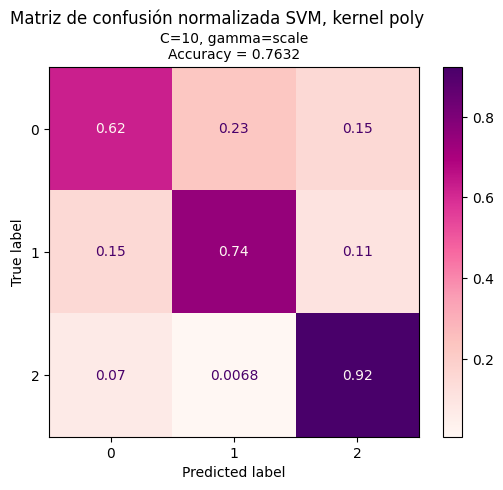

In [178]:
parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model_poly_all_feat = make_clf(svc, parameters, df_train, y_train, df_val, y_val)

y_pred = best_model_poly_all_feat.predict(df_val) # Predicción del conjunto de validación
folder = '/content/SVM/train/full_dataset/Grid_Search_best_poly/'
conf_mat(best_model_poly_all_feat, y_val, y_pred)

### Reducción de carcaterísticas preliminar (Solo medias)
Idea sustentada en la forma de las señales y la matriz de correlación

Matriz de confusión de solo las medias, esta idea está sustentada en el hecho de que la mayoría de las señales son líneas rectas o tienen una pendiente muy baja, teniendo esto en cuenta se plantea reducir el vector de carcaterísticas

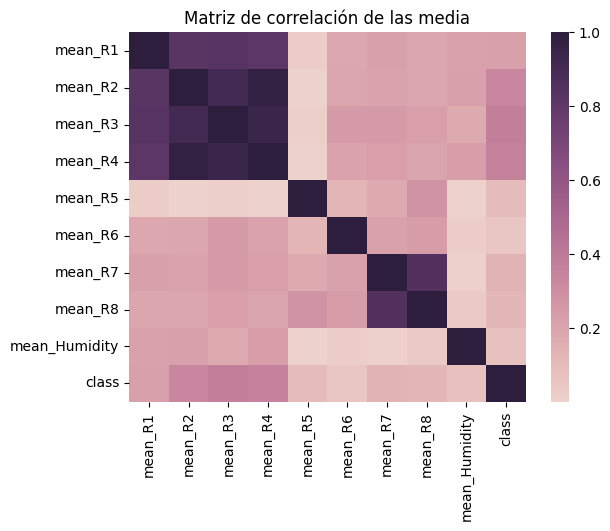

In [179]:
correlation_data_abs_value = abs(df_train[[col for col in df_train.columns if col.startswith('mean_')]].assign(**{'class': y_train}).corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las media")#, fontsize=20)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

gamma_default en función de los datos

In [218]:
gamma_default = 1 / (n_features * df_val.var().mean()) #gamma predefinido para todo el dataset

Se observó que al definir el gamma en función del vector de características completo, los resultados en validación fueron ligeramente inferiores pero superiores en test (Kaggle). diferencia entre la versión v8 y el archivo best_SVM

#### El mejor SVM con el conjunto reducido de características

Ojo que el gamma está calculado con el conjunto reucido de características

Tiempo GridSearch SVM lineal:  7.711277961730957


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.304769           0.0         0.160140             0.0        1   
1        0.274902           0.0         0.182312             0.0        1   
2        0.241592           0.0         0.130688             0.0        1   
3        0.179120           0.0         0.104578             0.0        1   
4        0.178862           0.0         0.097147             0.0        1   
5        0.284390           0.0         0.151259             0.0       10   
6        0.248014           0.0         0.136027             0.0       10   
7        0.196078           0.0         0.058833             0.0       10   
8        0.112558           0.0         0.056441             0.0       10   
9        0.089009           0.0         0.040781             0.0       10   
10       0.141361           0.0         0.072071             0.0      100   
11       0.139973           0.0         0.065266             0.0      100   
12       0.140753           0.0         0.054127             0.0      100   
13       0.162691           0.0         0.038958             0.0      100   
14       0.127375           0.0         0.035254             0.0      100   
15       0.147744           0.0         0.065646             0.0     1000   
16       0.170112           0.0         0.059617             0.0     1000   
17       0.282503           0.0         0.047032             0.0     1000   
18       0.470664           0.0         0.033930             0.0     1000   
19       0.141499           0.0         0.035239             0.0     1000   
20       0.156498           0.0         0.066170             0.0     2000   
21       0.206726           0.0         0.071479             0.0     2000   
22       0.396624           0.0         0.045367             0.0     2000   
23       0.644218           0.0         0.031650             0.0     2000   
24       0.156733           0.0         0.032037             0.0     2000   

    param_gamma                                       params  \
0      0.000089     {'C': 1, 'gamma': 8.857553769927608e-05}   
1      0.000886     {'C': 1, 'gamma': 0.0008857553769927609}   
2      0.008858      {'C': 1, 'gamma': 0.008857553769927608}   
3      0.088576       {'C': 1, 'gamma': 0.08857553769927609}   
4      0.885755        {'C': 1, 'gamma': 0.8857553769927609}   
5      0.000089    {'C': 10, 'gamma': 8.857553769927608e-05}   
6      0.000886    {'C': 10, 'gamma': 0.0008857553769927609}   
7      0.008858     {'C': 10, 'gamma': 0.008857553769927608}   
8      0.088576      {'C': 10, 'gamma': 0.08857553769927609}   
9      0.885755       {'C': 10, 'gamma': 0.8857553769927609}   
10     0.000089   {'C': 100, 'gamma': 8.857553769927608e-05}   
11     0.000886   {'C': 100, 'gamma': 0.0008857553769927609}   
12     0.008858    {'C': 100, 'gamma': 0.008857553769927608}   
13     0.088576     {'C': 100, 'gamma': 0.08857553769927609}   
14     0.885755      {'C': 100, 'gamma': 0.8857553769927609}   
15     0.000089  {'C': 1000, 'gamma': 8.857553769927608e-05}   
16     0.000886  {'C': 1000, 'gamma': 0.0008857553769927609}   
17     0.008858   {'C': 1000, 'gamma': 0.008857553769927608}   
18     0.088576    {'C': 1000, 'gamma': 0.08857553769927609}   
19     0.885755     {'C': 1000, 'gamma': 0.8857553769927609}   
20     0.000089  {'C': 2000, 'gamma': 8.857553769927608e-05}   
21     0.000886  {'C': 2000, 'gamma': 0.0008857553769927609}   
22     0.008858   {'C': 2000, 'gamma': 0.008857553769927608}   
23     0.088576    {'C': 2000, 'gamma': 0.08857553769927609}   
24     0.885755     {'C': 2000, 'gamma': 0.8857553769927609}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.309343         0.309343             0.0               25  
1            0.551768         0.551768             0.0               23  
2            0.651515         0.651515             0.0               19  
3            0.737374         0.737374  

Tiempo entrenamiento SVM lineal:  0.954376220703125
Tiempo GridSearch + Entrenamiento = 8.665654182434082


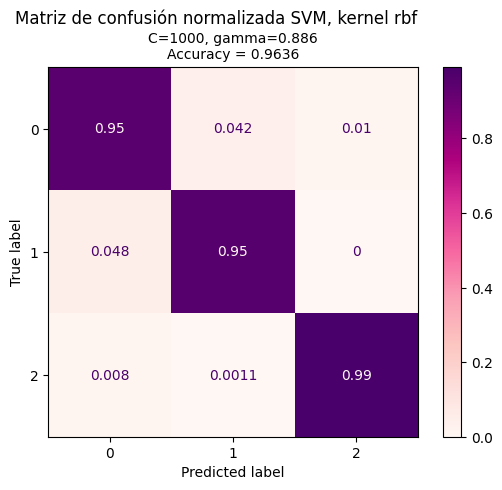

In [233]:
parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model_only_mean = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val) # Solo las medias de las mediciones de cada sensor (EMPÍRICO)

y_pred = best_model_only_mean.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación
folder = '/content/SVM/train/only_mean_dataset/grid_search/'
conf_mat(best_model_only_mean, y_val, y_pred)

El anterior resultó ser el mejor resultado en test, con un accuracy en test de 0.96!!!!!

### Selección de características mediante métodos más sofisticados

#### Reducción de carcaterísticas mediante SelectKBest
De esta forma sofisticamos un poco la reducción de características, y se puede optimizar el resultado del accuracy en función de las características

Este conjunto tiene las 12 características de las señales captadas por los sensores R_1, R_2, R_3, R_4, esto está basado en ele hecho de que ne esa zona de la matriz de confusión hay un color más oscuro, por la escala de colores esto significa una mayor correlación con la clase

In [183]:
# selector = SelectKBest(score_func=f_classif, k=9).fit(df_train, y_train)
selector = SelectKBest(score_func=f_classif, k=54).fit(df_train, y_train)
# selector = SelectKBest(score_func=f_classif, k=9).fit(df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train)

best_indx_filter = np.where(selector.get_support())[0]
best_feat_filter = [df_train.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:', best_feat_filter)

# # Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_filter = df_train[best_feat_filter]
df_val_filter = df_val[best_feat_filter]
df_test_filter = df_test[best_feat_filter]

Mejores características: ['mean_R1', 'var_R1', 'mad_R1', 'max_R1', 'min_R1', 'ran_R1', 'sma_R1', 'enrgy_R1', 'iqr_R1', 'entpy_R1', 'mean_R2', 'var_R2', 'mad_R2', 'max_R2', 'min_R2', 'ran_R2', 'sma_R2', 'enrgy_R2', 'iqr_R2', 'entpy_R2', 'mean_R3', 'var_R3', 'mad_R3', 'max_R3', 'min_R3', 'ran_R3', 'sma_R3', 'enrgy_R3', 'iqr_R3', 'entpy_R3', 'mean_R4', 'var_R4', 'mad_R4', 'max_R4', 'min_R4', 'ran_R4', 'sma_R4', 'enrgy_R4', 'iqr_R4', 'entpy_R4', 'mean_R6', 'mad_R6', 'max_R6', 'min_R6', 'ran_R6', 'sma_R6', 'iqr_R6', 'arCoeff_R6', 'corr_R6', 'min_R7', 'mad_Humidity', 'max_Humidity', 'ran_Humidity', 'iqr_Humidity']


Tiempo GridSearch SVM lineal:  10.96796727180481


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.220876           0.0         0.111072             0.0        1   
1        0.191177           0.0         0.094882             0.0        1   
2        0.164150           0.0         0.076221             0.0        1   
3        0.171337           0.0         0.090245             0.0        1   
4        0.278009           0.0         0.104509             0.0        1   
5        0.188273           0.0         0.101976             0.0       10   
6        0.172981           0.0         0.079420             0.0       10   
7        0.151478           0.0         0.068835             0.0       10   
8        0.205174           0.0         0.077311             0.0       10   
9        0.305801           0.0         0.105695             0.0       10   
10       0.187726           0.0         0.084752             0.0      100   
11       0.174169           0.0         0.071273             0.0      100   
12       0.203224           0.0         0.260802             0.0      100   
13       0.272400           0.0         0.070743             0.0      100   
14       0.324628           0.0         0.202459             0.0      100   
15       0.343454           0.0         0.138440             0.0     1000   
16       0.464112           0.0         0.116117             0.0     1000   
17       0.916907           0.0         0.104084             0.0     1000   
18       0.552110           0.0         0.102525             0.0     1000   
19       0.294194           0.0         0.104716             0.0     1000   
20       0.246668           0.0         0.071686             0.0     2000   
21       0.398481           0.0         0.065568             0.0     2000   
22       0.824912           0.0         0.054649             0.0     2000   
23       0.295010           0.0         0.069746             0.0     2000   
24       0.312774           0.0         0.103518             0.0     2000   

    param_gamma                                        params  \
0      0.000148     {'C': 1, 'gamma': 0.00014818141957161486}   
1      0.001482      {'C': 1, 'gamma': 0.0014818141957161487}   
2      0.014818       {'C': 1, 'gamma': 0.014818141957161485}   
3      0.148181        {'C': 1, 'gamma': 0.14818141957161485}   
4      1.481814         {'C': 1, 'gamma': 1.4818141957161486}   
5      0.000148    {'C': 10, 'gamma': 0.00014818141957161486}   
6      0.001482     {'C': 10, 'gamma': 0.0014818141957161487}   
7      0.014818      {'C': 10, 'gamma': 0.014818141957161485}   
8      0.148181       {'C': 10, 'gamma': 0.14818141957161485}   
9      1.481814        {'C': 10, 'gamma': 1.4818141957161486}   
10     0.000148   {'C': 100, 'gamma': 0.00014818141957161486}   
11     0.001482    {'C': 100, 'gamma': 0.0014818141957161487}   
12     0.014818     {'C': 100, 'gamma': 0.014818141957161485}   
13     0.148181      {'C': 100, 'gamma': 0.14818141957161485}   
14     1.481814       {'C': 100, 'gamma': 1.4818141957161486}   
15     0.000148  {'C': 1000, 'gamma': 0.00014818141957161486}   
16     0.001482   {'C': 1000, 'gamma': 0.0014818141957161487}   
17     0.014818    {'C': 1000, 'gamma': 0.014818141957161485}   
18     0.148181     {'C': 1000, 'gamma': 0.14818141957161485}   
19     1.481814      {'C': 1000, 'gamma': 1.4818141957161486}   
20     0.000148  {'C': 2000, 'gamma': 0.00014818141957161486}   
21     0.001482   {'C': 2000, 'gamma': 0.0014818141957161487}   
22     0.014818    {'C': 2000, 'gamma': 0.014818141957161485}   
23     0.148181     {'C': 2000, 'gamma': 0.14818141957161485}   
24     1.481814      {'C': 2000, 'gamma': 1.4818141957161486}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.522727         0.522727             0.0               25  
1            0.646465         0.646465             0.0               23  
2            0.702020         0.702020             0.0               20  
3            0

Tiempo entrenamiento SVM lineal:  2.831332206726074
Tiempo GridSearch + Entrenamiento = 13.799299478530884


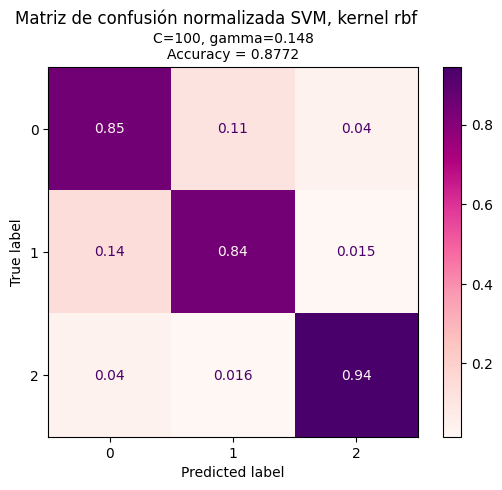

In [184]:
gamma_default = 1 / (df_val_filter.shape[1] * df_val_filter.var().mean())

parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

best_model_k_best = make_clf(svc, parameters, df_train_filter, y_train, df_val_filter, y_val)

y_pred_filter = best_model_k_best.predict(df_val_filter)
folder = '/content/SVM/train/filter_method_dataset/grid_search/'
conf_mat(best_model_k_best, y_val, y_pred_filter)

#### Selección de características mediante *wrapper strategy*

In [185]:
# Asegúrate de que el SVC sea lineal
svc = svm.SVC(kernel='linear', C=10)
svc.fit(df_train, y_train)

# selector = SelectFromModel(estimator=svc, prefit=True, max_features=54, importance_getter='coef_') #Investigar que es prefit
selector = SelectFromModel(estimator=svc, max_features=54, threshold=-np.inf)

best_indx_wrapper = np.where(selector.get_support())[0]
best_feat_wrapper = [df_train.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:',best_feat_wrapper)
# Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_wrapper = df_train[best_feat_wrapper]
df_val_wrapper = df_val[best_feat_wrapper]
df_test_wrapper = df_test[best_feat_wrapper]

Mejores características: ['mean_R1', 'var_R1', 'max_R1', 'sma_R1', 'enrgy_R1', 'iqr_R1', 'entpy_R1', 'mean_R2', 'var_R2', 'mad_R2', 'ran_R2', 'sma_R2', 'enrgy_R2', 'iqr_R2', 'entpy_R2', 'mean_R3', 'var_R3', 'max_R3', 'min_R3', 'sma_R3', 'enrgy_R3', 'entpy_R3', 'mean_R4', 'var_R4', 'max_R4', 'min_R4', 'ran_R4', 'sma_R4', 'enrgy_R4', 'iqr_R4', 'enrgy_R5', 'mean_R6', 'var_R6', 'mad_R6', 'max_R6', 'min_R6', 'ran_R6', 'sma_R6', 'enrgy_R6', 'entpy_R6', 'mean_R7', 'var_R7', 'mad_R7', 'max_R7', 'min_R7', 'ran_R7', 'sma_R7', 'enrgy_R7', 'iqr_R7', 'var_R8', 'enrgy_R8', 'max_Humidity', 'min_Humidity', 'enrgy_Humidity']


Tiempo GridSearch SVM lineal:  18.520174264907837


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.407649           0.0         0.192538             0.0        1   
1        0.454257           0.0         0.311107             0.0        1   
2        0.497885           0.0         0.198384             0.0        1   
3        0.302892           0.0         0.192601             0.0        1   
4        0.958136           0.0         0.417935             0.0        1   
5        0.357105           0.0         0.171564             0.0       10   
6        0.321761           0.0         0.145509             0.0       10   
7        0.250512           0.0         0.123818             0.0       10   
8        0.244817           0.0         0.117715             0.0       10   
9        0.979175           0.0         0.424784             0.0       10   
10       0.332521           0.0         0.104459             0.0      100   
11       0.216005           0.0         0.124944             0.0      100   
12       0.345106           0.0         0.153928             0.0      100   
13       0.339820           0.0         0.134066             0.0      100   
14       0.817411           0.0         0.377996             0.0      100   
15       1.146836           0.0         0.445816             0.0     1000   
16       1.143189           0.0         0.142966             0.0     1000   
17       1.092972           0.0         0.108280             0.0     1000   
18       0.514979           0.0         0.160379             0.0     1000   
19       0.621700           0.0         0.162955             0.0     1000   
20       0.563843           0.0         0.176765             0.0     2000   
21       0.555397           0.0         0.062086             0.0     2000   
22       0.626451           0.0         0.046795             0.0     2000   
23       0.192871           0.0         0.049454             0.0     2000   
24       0.268507           0.0         0.081020             0.0     2000   

    param_gamma                                        params  \
0      0.000176     {'C': 1, 'gamma': 0.00017625053399005178}   
1      0.001763      {'C': 1, 'gamma': 0.0017625053399005178}   
2      0.017625       {'C': 1, 'gamma': 0.017625053399005178}   
3      0.176251        {'C': 1, 'gamma': 0.17625053399005178}   
4      1.762505         {'C': 1, 'gamma': 1.7625053399005177}   
5      0.000176    {'C': 10, 'gamma': 0.00017625053399005178}   
6      0.001763     {'C': 10, 'gamma': 0.0017625053399005178}   
7      0.017625      {'C': 10, 'gamma': 0.017625053399005178}   
8      0.176251       {'C': 10, 'gamma': 0.17625053399005178}   
9      1.762505        {'C': 10, 'gamma': 1.7625053399005177}   
10     0.000176   {'C': 100, 'gamma': 0.00017625053399005178}   
11     0.001763    {'C': 100, 'gamma': 0.0017625053399005178}   
12     0.017625     {'C': 100, 'gamma': 0.017625053399005178}   
13     0.176251      {'C': 100, 'gamma': 0.17625053399005178}   
14     1.762505       {'C': 100, 'gamma': 1.7625053399005177}   
15     0.000176  {'C': 1000, 'gamma': 0.00017625053399005178}   
16     0.001763   {'C': 1000, 'gamma': 0.0017625053399005178}   
17     0.017625    {'C': 1000, 'gamma': 0.017625053399005178}   
18     0.176251     {'C': 1000, 'gamma': 0.17625053399005178}   
19     1.762505      {'C': 1000, 'gamma': 1.7625053399005177}   
20     0.000176  {'C': 2000, 'gamma': 0.00017625053399005178}   
21     0.001763   {'C': 2000, 'gamma': 0.0017625053399005178}   
22     0.017625    {'C': 2000, 'gamma': 0.017625053399005178}   
23     0.176251     {'C': 2000, 'gamma': 0.17625053399005178}   
24     1.762505      {'C': 2000, 'gamma': 1.7625053399005177}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.549242         0.549242             0.0               25  
1            0.643939         0.643939             0.0               23  
2            0.713384         0.713384             0.0               19  
3            0

Tiempo entrenamiento SVM lineal:  1.3049609661102295
Tiempo GridSearch + Entrenamiento = 19.825135231018066


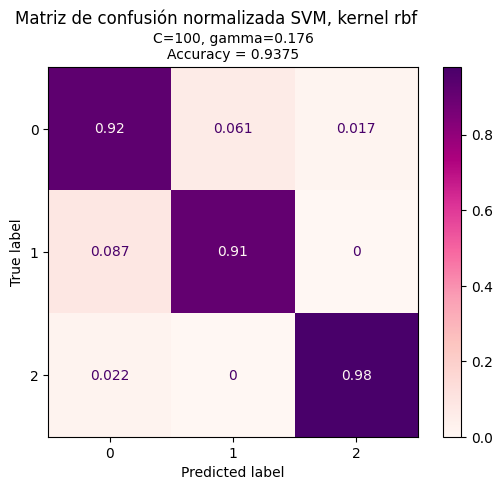

In [186]:
gamma_default = 1 / (df_val_wrapper.shape[1] * df_val_wrapper.var().mean())

parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model_wrapper = make_clf(svc, parameters, df_train_wrapper, y_train, df_val_wrapper, y_val)

y_pred_wrapper = best_model_wrapper.predict(df_val_wrapper)
folder = '/content/SVM/train/filter_method_dataset/grid_search/'
conf_mat(best_model_wrapper, y_val, y_pred_wrapper)

#### Selección de carcaterísticas mediante PCA

In [126]:
pca = PCA(n_components=54)
pca.fit(df_train)

df_train_pca = pd.DataFrame(pca.transform(df_train))
df_val_pca = pd.DataFrame(pca.transform(df_val))
df_test_pca = pd.DataFrame(pca.transform(df_test))

Tiempo GridSearch SVM lineal:  11.263745307922363


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.221812           0.0         0.111693             0.0        1   
1        0.229765           0.0         0.093731             0.0        1   
2        0.164388           0.0         0.079623             0.0        1   
3        0.210528           0.0         0.093028             0.0        1   
4        0.316414           0.0         0.114496             0.0        1   
5        0.182986           0.0         0.092987             0.0       10   
6        0.166094           0.0         0.081163             0.0       10   
7        0.276428           0.0         0.148640             0.0       10   
8        0.442853           0.0         0.172134             0.0       10   
9        0.474319           0.0         0.202643             0.0       10   
10       0.295730           0.0         0.146013             0.0      100   
11       0.330174           0.0         0.125862             0.0      100   
12       0.356618           0.0         0.068308             0.0      100   
13       0.279252           0.0         0.090427             0.0      100   
14       0.293485           0.0         0.114051             0.0      100   
15       0.232547           0.0         0.074582             0.0     1000   
16       0.441017           0.0         0.081330             0.0     1000   
17       0.529243           0.0         0.063062             0.0     1000   
18       0.278086           0.0         0.087112             0.0     1000   
19       0.298435           0.0         0.116047             0.0     1000   
20       0.284748           0.0         0.073704             0.0     2000   
21       0.616695           0.0         0.065476             0.0     2000   
22       0.654110           0.0         0.062465             0.0     2000   
23       0.291368           0.0         0.089733             0.0     2000   
24       0.292488           0.0         0.112085             0.0     2000   

    param_gamma                                      params  \
0      0.000090     {'C': 1, 'gamma': 8.96363371048437e-05}   
1      0.000896     {'C': 1, 'gamma': 0.000896363371048437}   
2      0.008964      {'C': 1, 'gamma': 0.00896363371048437}   
3      0.089636       {'C': 1, 'gamma': 0.0896363371048437}   
4      0.896363        {'C': 1, 'gamma': 0.896363371048437}   
5      0.000090    {'C': 10, 'gamma': 8.96363371048437e-05}   
6      0.000896    {'C': 10, 'gamma': 0.000896363371048437}   
7      0.008964     {'C': 10, 'gamma': 0.00896363371048437}   
8      0.089636      {'C': 10, 'gamma': 0.0896363371048437}   
9      0.896363       {'C': 10, 'gamma': 0.896363371048437}   
10     0.000090   {'C': 100, 'gamma': 8.96363371048437e-05}   
11     0.000896   {'C': 100, 'gamma': 0.000896363371048437}   
12     0.008964    {'C': 100, 'gamma': 0.00896363371048437}   
13     0.089636     {'C': 100, 'gamma': 0.0896363371048437}   
14     0.896363      {'C': 100, 'gamma': 0.896363371048437}   
15     0.000090  {'C': 1000, 'gamma': 8.96363371048437e-05}   
16     0.000896  {'C': 1000, 'gamma': 0.000896363371048437}   
17     0.008964   {'C': 1000, 'gamma': 0.00896363371048437}   
18     0.089636    {'C': 1000, 'gamma': 0.0896363371048437}   
19     0.896363     {'C': 1000, 'gamma': 0.896363371048437}   
20     0.000090  {'C': 2000, 'gamma': 8.96363371048437e-05}   
21     0.000896  {'C': 2000, 'gamma': 0.000896363371048437}   
22     0.008964   {'C': 2000, 'gamma': 0.00896363371048437}   
23     0.089636    {'C': 2000, 'gamma': 0.0896363371048437}   
24     0.896363     {'C': 2000, 'gamma': 0.896363371048437}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.539141         0.539141             0.0               25  
1            0.652778         0.652778             0.0               19  
2            0.713384         0.713384             0.0                8  
3            0.704545         0.704545             0.0            

Tiempo entrenamiento SVM lineal:  2.8408291339874268
Tiempo GridSearch + Entrenamiento = 14.10457444190979


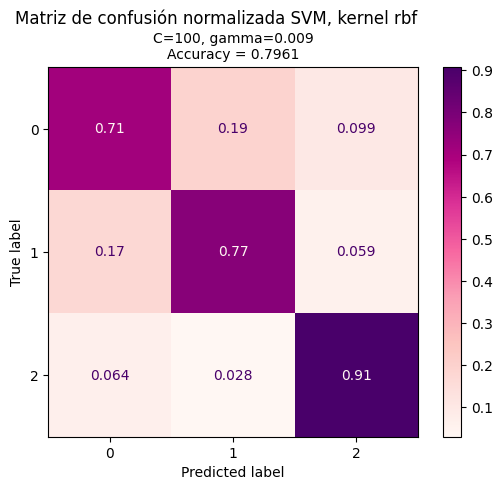

In [187]:
gamma_default = 1 / (df_val_pca.shape[1] * df_val_pca.var().mean())

parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model = make_clf(svc, parameters, df_train_pca, y_train, df_val_pca, y_val)

y_pred_pca = best_model.predict(df_val_pca)
folder = '/content/SVM/train/PCA_method_dataset/grid_search/'
conf_mat(best_model, y_val, y_pred_pca)

#### Selección de carcaterísticas, máxima derivada y media

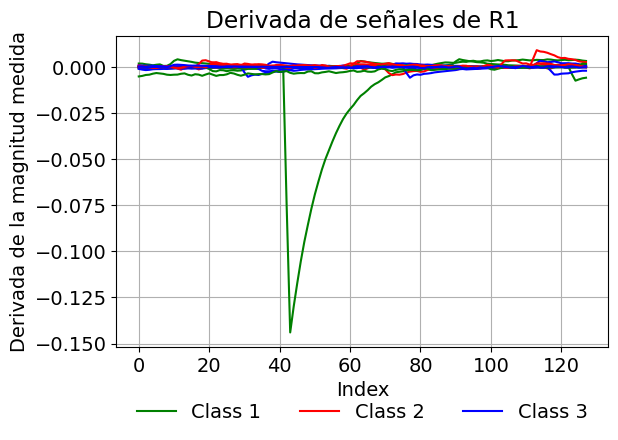

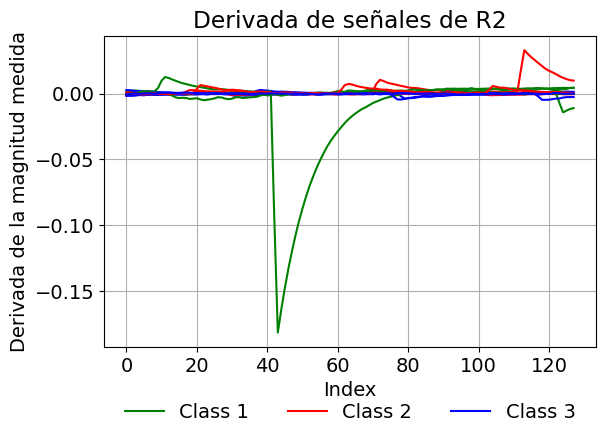

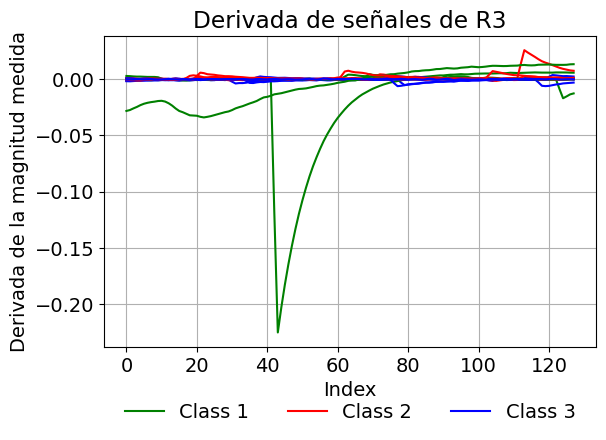

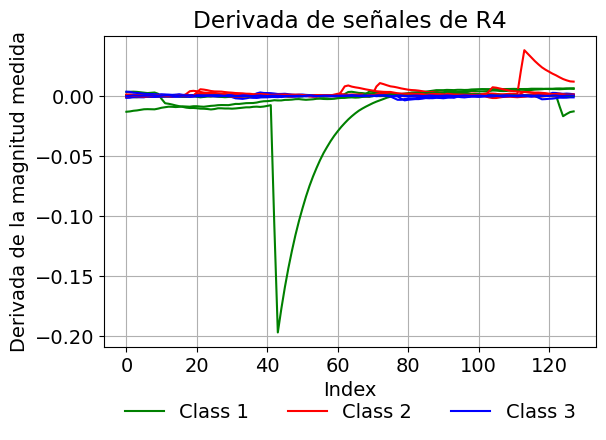

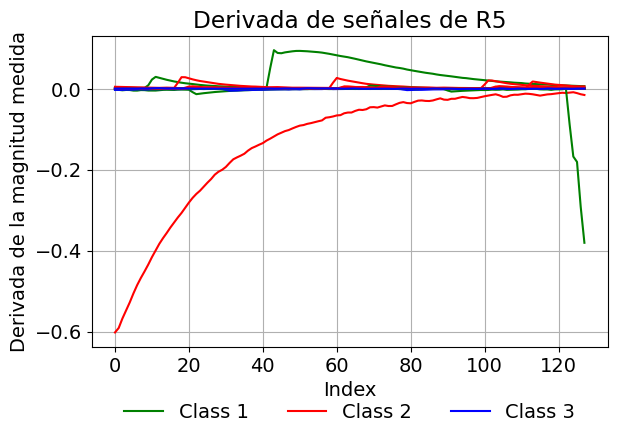

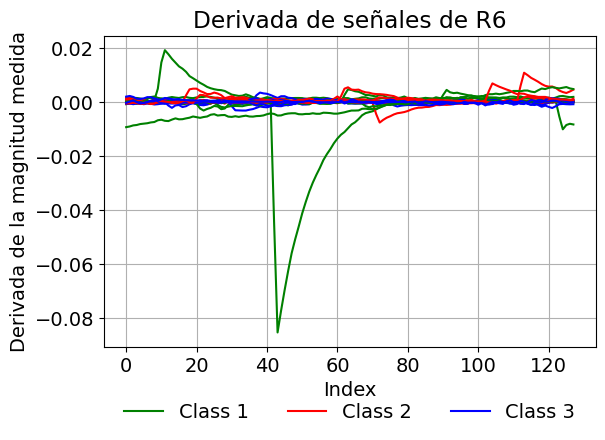

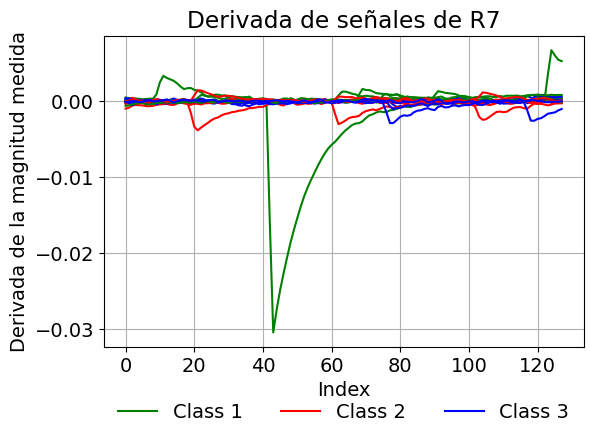

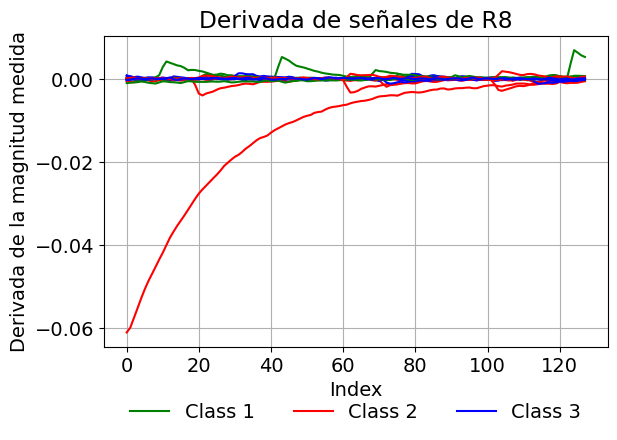

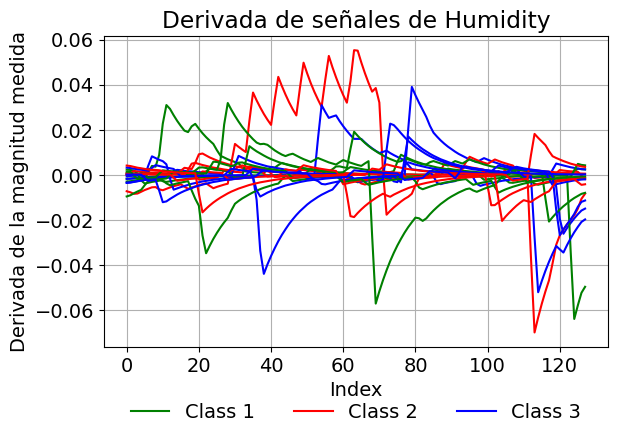

In [138]:
num_sign_per_graph = 6
rs = 20
folder = '/content/SVM/train/mean_and_gradient_dataset/' # Ruta para guardar los gráficos, variable global en este punto
os.makedirs(folder, exist_ok=True)

# Definición única de parámetros gráficos
plot_kwargs_1 = {'color': 'green','label': 'Class 1'}
plot_kwargs_2 = {'color': 'red', 'label': 'Class 2'}
plot_kwargs_3 = {'color': 'blue', 'label': 'Class 3'}
plt.rcParams.update({'font.size': 14})  # Cambia el número según el tamaño deseado

for start in range(9):
  idx = [start*128, start*128 + 128]

  plt.figure()
  plt.grid()
  plt.xlabel('Index')
  plt.ylabel('Derivada de la magnitud medida')

  plt.title(f'Derivada de señales de {df_trainval.iloc[:, idx[0]:idx[1]].keys()[0][:-2]}')

  for i in range(num_sign_per_graph):
    plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]]), **plot_kwargs_1)
    plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]]), **plot_kwargs_2)
    plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]]), **plot_kwargs_3)
    if i == 0:
      plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3), ncol=3, frameon=False)
      plt.tight_layout()  # Ajusta el layout para que no se corte nada

  filename = f'gradient_signals_{df_trainval.iloc[:, idx[0]:idx[1]].keys()[0][:-2]}.pdf'

  filepath = os.path.join(folder, filename)
  plt.savefig(filepath)
  plt.show()

import zipfile
import glob

with zipfile.ZipFile('/content/SVM/train/mean_and_gradient_dataset.zip', "w") as zipf:
    for file in glob.glob('/content/SVM/train/mean_and_gradient_dataset/*.pdf'):
        zipf.write(file, arcname=file.split("/")[-1])

##### Cálculo de un nuevo vector de cracterísticas más intuitivas
Tales como pendiente, derivada, carcaterísticas asociadas a la monotonía de las funciones

In [188]:
def extract_features_II(signal):

  return {
      'mean': np.mean(signal),
      'max_grad': max(abs(np.gradient(signal)))
  }

def calculation_feature_vector_II(df_data):
    sensors = [f'R{j}' for j in range(1, 9)] + ['Humidity']
    feature_list = []

    for idx, row in df_data.iterrows():
        features = {}
        for sensor in sensors:
            start_col = f'{sensor}_0'
            end_col = f'{sensor}_127'
            signal = row[start_col:end_col].to_numpy()
            feats = extract_features_II(signal)

            # Prefix feature names with sensor ID
            feats_prefixed = {f'{key}_{sensor}': value for key, value in feats.items()}
            features.update(feats_prefixed)
        if 'class' in df_data.columns:
            features['class'] = row['class']
        feature_list.append(features)

    df_features = pd.DataFrame(feature_list)
    return df_features

##### Cálculo del vector de cracterísticas

In [191]:
train_val_data_II = calculation_feature_vector_II(df_trainval)
df_test_data_II = calculation_feature_vector_II(df_test_no_labels)

In [201]:
df_train_II, df_val_II = train_test_split(train_val_data_II, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])
df_test_II = df_test_data_II.copy()

In [202]:
# df_test = calculation_feature_vector(df_test_no_labels)
scaler = StandardScaler().fit(df_train_II.iloc[:,0:-1])

df_train_II.iloc[:,0:-1] = scaler.transform(df_train_II.iloc[:,0:-1])
df_val_II.iloc[:,0:-1] = scaler.transform(df_val_II.iloc[:,0:-1])
df_test_II.iloc[:,0:] = scaler.transform(df_test_II.iloc[:,0:])

df_train_w_class_II = df_train_II.copy()
df_val_w_class_II = df_val_II.copy()

y_train = df_train_II.pop('class')# - 1
y_val = df_val_II.pop('class')# - 1

##### Matriz de correlación

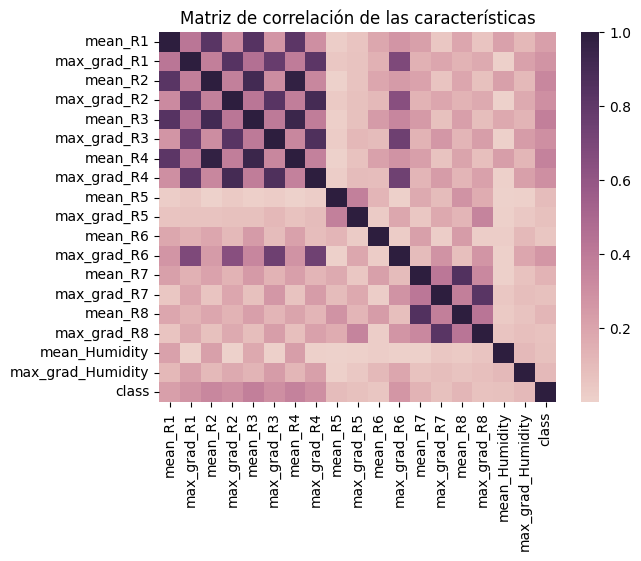

In [203]:
plt.rcParams.update({'font.size': 10})  # Cambia el número según el tamaño deseado
# correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class_II.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=12)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Tiempo GridSearch SVM lineal:  9.535401344299316


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.179818           0.0         0.107562             0.0        1   
1        0.150011           0.0         0.072365             0.0        1   
2        0.117263           0.0         0.059543             0.0        1   
3        0.163354           0.0         0.061355             0.0        1   
4        0.226764           0.0         0.075523             0.0        1   
5        0.167438           0.0         0.071489             0.0       10   
6        0.130911           0.0         0.060332             0.0       10   
7        0.122273           0.0         0.052806             0.0       10   
8        0.152253           0.0         0.054091             0.0       10   
9        0.228118           0.0         0.096057             0.0       10   
10       0.145114           0.0         0.063922             0.0      100   
11       0.150383           0.0         0.052721             0.0      100   
12       0.230572           0.0         0.084032             0.0      100   
13       0.303405           0.0         0.087721             0.0      100   
14       0.393868           0.0         0.133297             0.0      100   
15       0.299101           0.0         0.110277             0.0     1000   
16       0.508694           0.0         0.086641             0.0     1000   
17       0.782114           0.0         0.038439             0.0     1000   
18       0.310041           0.0         0.155367             0.0     1000   
19       0.446991           0.0         0.140994             0.0     1000   
20       0.443200           0.0         0.062125             0.0     2000   
21       0.449442           0.0         0.047030             0.0     2000   
22       0.698577           0.0         0.036258             0.0     2000   
23       0.209525           0.0         0.047041             0.0     2000   
24       0.226092           0.0         0.075282             0.0     2000   

    param_gamma                                       params  \
0      0.000583     {'C': 1, 'gamma': 0.0005829141633940371}   
1      0.005829      {'C': 1, 'gamma': 0.005829141633940372}   
2      0.058291       {'C': 1, 'gamma': 0.05829141633940371}   
3      0.582914        {'C': 1, 'gamma': 0.5829141633940371}   
4      5.829142         {'C': 1, 'gamma': 5.829141633940371}   
5      0.000583    {'C': 10, 'gamma': 0.0005829141633940371}   
6      0.005829     {'C': 10, 'gamma': 0.005829141633940372}   
7      0.058291      {'C': 10, 'gamma': 0.05829141633940371}   
8      0.582914       {'C': 10, 'gamma': 0.5829141633940371}   
9      5.829142        {'C': 10, 'gamma': 5.829141633940371}   
10     0.000583   {'C': 100, 'gamma': 0.0005829141633940371}   
11     0.005829    {'C': 100, 'gamma': 0.005829141633940372}   
12     0.058291     {'C': 100, 'gamma': 0.05829141633940371}   
13     0.582914      {'C': 100, 'gamma': 0.5829141633940371}   
14     5.829142       {'C': 100, 'gamma': 5.829141633940371}   
15     0.000583  {'C': 1000, 'gamma': 0.0005829141633940371}   
16     0.005829   {'C': 1000, 'gamma': 0.005829141633940372}   
17     0.058291    {'C': 1000, 'gamma': 0.05829141633940371}   
18     0.582914     {'C': 1000, 'gamma': 0.5829141633940371}   
19     5.829142      {'C': 1000, 'gamma': 5.829141633940371}   
20     0.000583  {'C': 2000, 'gamma': 0.0005829141633940371}   
21     0.005829   {'C': 2000, 'gamma': 0.005829141633940372}   
22     0.058291    {'C': 2000, 'gamma': 0.05829141633940371}   
23     0.582914     {'C': 2000, 'gamma': 0.5829141633940371}   
24     5.829142      {'C': 2000, 'gamma': 5.829141633940371}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.558081         0.558081             0.0               25  
1            0.670455         0.670455             0.0               23  
2            0.737374         0.737374             0.0               18  
3            0.782828         0.782828  

Tiempo entrenamiento SVM lineal:  2.045555591583252
Tiempo GridSearch + Entrenamiento = 11.580956935882568


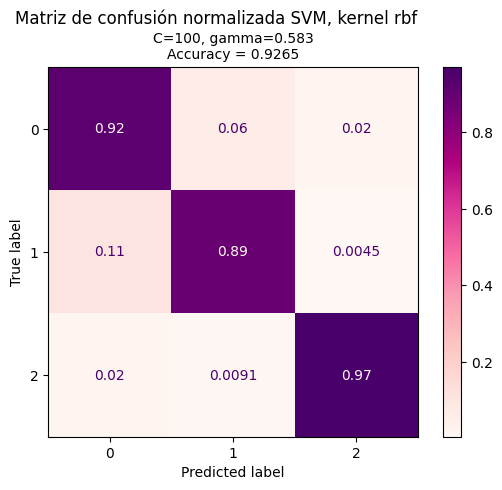

In [204]:
gamma_default = 1 / (df_val_II.shape[1] * df_val_II.var().mean())

parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')
best_model_mean_grad_dataset = make_clf(svc, parameters, df_train_II, y_train, df_val_II, y_val)

y_pred = best_model_mean_grad_dataset.predict(df_val_II) # Predicción del conjunto de validación
folder = '/content/SVM/train/new_feature_vector/grid_search/'
conf_mat(best_model_mean_grad_dataset, y_val, y_pred)

### Reducción de carcaterísticas

In [213]:
# Asegúrate de que el SVC sea lineal
svc = svm.SVC(kernel='linear', C=10)
svc.fit(df_train_II, y_train)

# selector = SelectFromModel(estimator=svc, prefit=True, max_features=54, importance_getter='coef_') #Investigar que es prefit
selector = SelectFromModel(estimator=svc, max_features=9, threshold=-np.inf)

best_indx_wrapper = np.where(selector.get_support())[0]
best_feat_wrapper = [df_train_II.keys()[i] for i in np.where(selector.get_support())[0]] #Toma los indices de aquellas características que fueron seleccionadas como importantes con el método y luego busca el nombre de la característica correspodiente en la lista original de nombres definida al inicio del código

print('Mejores características:',best_feat_wrapper)
# Se define el nuevo conjunto de entrenamiento y validación tomando las características más importantes encontradas con este método
df_train_II_wrapper = df_train_II[best_feat_wrapper]
df_val_II_wrapper = df_val_II[best_feat_wrapper]
df_test_II_wrapper = df_test_II[best_feat_wrapper]

Mejores características: ['mean_R1', 'mean_R2', 'max_grad_R2', 'mean_R3', 'mean_R4', 'mean_R5', 'mean_R6', 'max_grad_R6', 'max_grad_R7']


Tiempo GridSearch SVM lineal:  11.388983249664307


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.176467           0.0         0.080771             0.0        1   
1        0.134878           0.0         0.069047             0.0        1   
2        0.110179           0.0         0.055569             0.0        1   
3        0.124301           0.0         0.056911             0.0        1   
4        0.161653           0.0         0.073772             0.0        1   
5        0.154984           0.0         0.070636             0.0       10   
6        0.121812           0.0         0.057656             0.0       10   
7        0.119359           0.0         0.051172             0.0       10   
8        0.123104           0.0         0.050328             0.0       10   
9        0.193009           0.0         0.060991             0.0       10   
10       0.157690           0.0         0.064815             0.0      100   
11       0.138665           0.0         0.052477             0.0      100   
12       0.164443           0.0         0.046014             0.0      100   
13       0.190447           0.0         0.044459             0.0      100   
14       0.189187           0.0         0.077669             0.0      100   
15       0.178454           0.0         0.057053             0.0     1000   
16       0.298229           0.0         0.048523             0.0     1000   
17       0.603102           0.0         0.082449             0.0     1000   
18       0.932389           0.0         0.073308             0.0     1000   
19       0.365807           0.0         0.104417             0.0     1000   
20       0.357906           0.0         0.188675             0.0     2000   
21       1.167232           0.0         0.091183             0.0     2000   
22       1.405189           0.0         0.081288             0.0     2000   
23       1.183369           0.0         0.071914             0.0     2000   
24       0.421086           0.0         0.105950             0.0     2000   

    param_gamma                                      params  \
0      0.001134     {'C': 1, 'gamma': 0.001134146772129865}   
1      0.011341      {'C': 1, 'gamma': 0.01134146772129865}   
2      0.113415       {'C': 1, 'gamma': 0.1134146772129865}   
3      1.134147        {'C': 1, 'gamma': 1.134146772129865}   
4     11.341468       {'C': 1, 'gamma': 11.341467721298649}   
5      0.001134    {'C': 10, 'gamma': 0.001134146772129865}   
6      0.011341     {'C': 10, 'gamma': 0.01134146772129865}   
7      0.113415      {'C': 10, 'gamma': 0.1134146772129865}   
8      1.134147       {'C': 10, 'gamma': 1.134146772129865}   
9     11.341468      {'C': 10, 'gamma': 11.341467721298649}   
10     0.001134   {'C': 100, 'gamma': 0.001134146772129865}   
11     0.011341    {'C': 100, 'gamma': 0.01134146772129865}   
12     0.113415     {'C': 100, 'gamma': 0.1134146772129865}   
13     1.134147      {'C': 100, 'gamma': 1.134146772129865}   
14    11.341468     {'C': 100, 'gamma': 11.341467721298649}   
15     0.001134  {'C': 1000, 'gamma': 0.001134146772129865}   
16     0.011341   {'C': 1000, 'gamma': 0.01134146772129865}   
17     0.113415    {'C': 1000, 'gamma': 0.1134146772129865}   
18     1.134147     {'C': 1000, 'gamma': 1.134146772129865}   
19    11.341468    {'C': 1000, 'gamma': 11.341467721298649}   
20     0.001134  {'C': 2000, 'gamma': 0.001134146772129865}   
21     0.011341   {'C': 2000, 'gamma': 0.01134146772129865}   
22     0.113415    {'C': 2000, 'gamma': 0.1134146772129865}   
23     1.134147     {'C': 2000, 'gamma': 1.134146772129865}   
24    11.341468    {'C': 2000, 'gamma': 11.341467721298649}   

    split0_test_score  mean_test_score  std_test_score  rank_test_score  
0            0.555556         0.555556             0.0               25  
1            0.657828         0.657828             0.0               23  
2            0.705808         0.705808             0.0               18  
3            0.758838         0.758838             0.0            

Tiempo entrenamiento SVM lineal:  1.7430198192596436
Tiempo GridSearch + Entrenamiento = 13.13200306892395


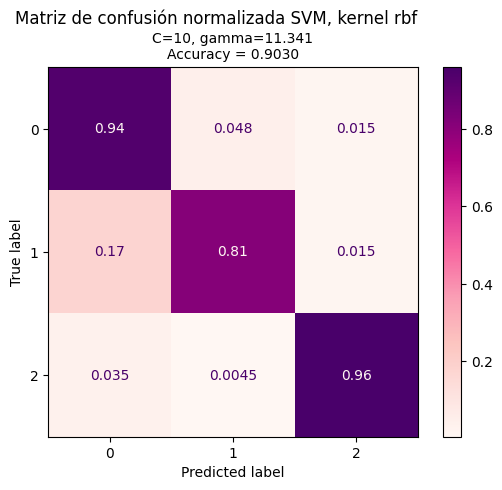

In [214]:
gamma_default = 1 / (df_val_II_wrapper.shape[1] * df_val_II_wrapper.var().mean())

parameters = {'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
svc = svm.SVC(kernel='rbf')

# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

best_model_wrapper = make_clf(svc, parameters, df_train_II_wrapper, y_train, df_val_II_wrapper, y_val)

y_pred_II_wrapper = best_model_wrapper.predict(df_val_II_wrapper)
folder = '/content/SVM/train/new_feature_vector/filter_method/grid_search/'
conf_mat(best_model_wrapper, y_val, y_pred_II_wrapper)

# Predicción del conjunto de test

In [234]:
best_model_only_mean

SVC(C=1000, gamma=np.float64(0.8857553769927609))

In [236]:
# y_pred_test = best_model.predict(df_test)
y_pred_test = best_model_only_mean.predict(df_test[[col for col in df_test.columns if col.startswith('mean_')]])

with open('pred_test_best_SVM.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_pred_test[i])}\n')

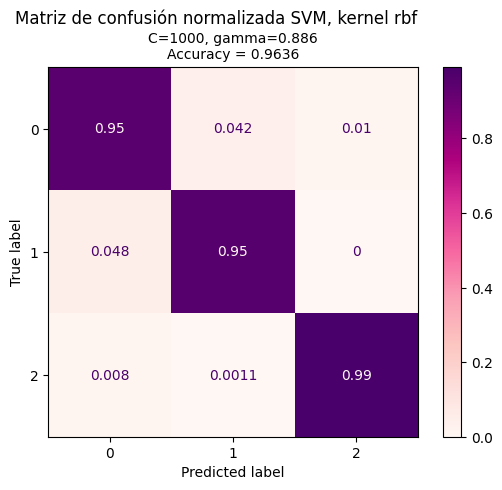

In [235]:
y_predd = best_model_only_mean.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]])
folder = '/content/borradores/'
conf_mat(best_model_only_mean, y_val, y_predd)

#

# 7) b) **Clasificador ANN**

In [ ]:
!pip install pytorch-ignite
!pip install early-stopping-pytorch
from ignite.engine import Engine, Events
from ignite.handlers import EarlyStopping
from ignite.metrics import Loss
from early_stopping_pytorch import EarlyStopping
import torch.nn.functional as F

# Funciones necesarias

### Entrenamiento y validación

Se define una modificación del código base de EarlyStopping de Pytorch con el propósito de evitar que imprima cada vez que está guardando el modelo y la cuenta de cuantas épocas han pasado desde que el loss comenzó a subir de nuevo

In [ ]:
# Sustituye esto:
from early_stopping_pytorch import EarlyStopping

# Por esto (versión propia):
class EarlyStoppingCustom:
    def __init__(self, patience=15, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float("inf")

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Guarda el modelo si ha habido mejora'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'best_model.pt')
        self.val_loss_min = val_loss


Esta función se utiliza para entrenar el modelo y validarlo

In [ ]:
# def train_model(model, patience, n_epochs, optimizer):
def train_model_generic(model, patience, n_epochs, optimizer, dataloader_tr, dataloader_vl):

  # Listas para guardar valores de loss por cada batch y por cada época
  train_losses = []
  valid_losses = []
  # Listas para guardar los pesos de cada batch, depende del tamaño de cada batch, esto es importante porque el último batch siempre es más pequeño
  batch_weights_train = []
  batch_weights_val = []
  # Listas para guardar la pérdida promedio de cada época
  avg_train_losses = []
  avg_valid_losses = []
  #Bandera para guardar el modelo una única vez bajo el nombre best_model.pt
  model_saved = False

  # initialize the early_stopping object
  early_stopping = EarlyStoppingCustom(patience=patience, verbose=False)

  start = time.time()
  for epoch in range(1, n_epochs + 1):

    # Entrenamiento
    model.train() # prep model for training

    for batch in dataloader_train:
      inputs = batch["features"].to(device)
      targets = batch["labels"].to(device) # Correponde a las clases de los datos

      # Igualar a 0 los gradientes de todas las variables optimizadas
      optimizer.zero_grad()
      # Predicciones
      output = model(inputs)
      # Cálculo de la pérdida
      loss = criterion(output, targets)
      # backward pass
      loss.backward()
      # Actualización de parámetros de la red (mediante Adam)
      optimizer.step()
      train_losses.append(loss.item())
      batch_weights_train.append(targets.size(0))

    # Validación
    model.eval()
    with torch.no_grad():
      for batch in dataloader_val:
        inputs = batch["features"].to(device)
        targets = batch["labels"].to(device)

        # Predicciones
        output = model(inputs)
        # Cálculo de la pérdida
        loss = criterion(output, targets)
        # Loss de validación de un solo batch
        valid_losses.append(loss.item())
        batch_weights_val.append(targets.size(0))


    train_loss = np.average(np.array(train_losses), weights = np.array(batch_weights_train))
    valid_loss = np.average(np.array(valid_losses), weights = np.array(batch_weights_val))

    # Se calcula el promedio del loss de todas las épocas
    avg_train_losses.append(train_loss)
    avg_valid_losses.append(valid_loss)

    epoch_len = len(str(n_epochs))

    print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' + f'train_loss: {train_loss:.6f} ' + f'valid_loss: {valid_loss:.6f}')
    # print(print_msg)

    # Se reinician las listas para guardar los valores de loss y los pesos de cada batch de la siguiente época
    train_losses = []
    valid_losses = []
    batch_weights_train = []
    batch_weights_val = []

    early_stopping(valid_loss, model)

    if early_stopping.early_stop and not model_saved:
        best_epoch = epoch - patience
        val_loss_min = avg_valid_losses[best_epoch - 1]
        print('Early stopping at -------------------------------------------------->',best_epoch)
        torch.save(model.state_dict(), 'best_model.pt') # En la línea a continuación se guarda el último checkpoint guardado por earlystopping, despues no se vuelve a guardar bajo este mismo nombre, de manera que este es el mejor modelo basado en patience early stopping
        model_saved = True
        training_time = time.time() - start # Se calcula aqui porque el modelo puede terminar de entrenarse antes de las 1000 épocas, por lo tanto, no sería correcto calcularlo al final, ya que el loss de validación y entrenamiento que se sigue calculando es para ver que tanto diverge el de validación en comparación al de entrenamiento para la totalidad de las épocas

  # Cargar el mejor modelo guardado con el criterio de patience early stopping
  model.load_state_dict(torch.load('best_model.pt', weights_only=True))
  print(f"Mejor modelo en la época {best_epoch} con loss de validación = {val_loss_min:.6f}")

  return  model, avg_train_losses, avg_valid_losses, training_time, best_epoch, dataloader_tr, dataloader_vl

### Gráficos de resultados

In [ ]:
def results_ANN(model, train_loss_values, valid_loss_values, t_time, best_ep, dataloader_tr, dataloader_vl):
    os.makedirs(ruta, exist_ok=True)

    # Obtener el nombre del modelo
    nombre_red = model.name  # Devuelve: 'MiRed'
    epochs = np.linspace(1, len(train_loss_values), len(train_loss_values))
    loss_valid_best_epoch = valid_loss_values[best_ep - 1]
    loss_train_best_epoch = train_loss_values[best_ep - 1]

    # Gráfico de loss de validación y entrenamiento
    prop = 0.95
    figsize = (prop*6.4, 0.95*4.8)
    plt.figure(figsize = figsize)
    plt.plot(epochs, train_loss_values, lw=1, color='blue', label='Train')
    plt.plot(epochs, valid_loss_values, lw=1, color='red', label='Validation')
    plt.axvline(x=best_ep, color='black', ls='--', lw=1)#, label='Best epoch')
    plt.text(x=best_ep, y=0.8, s=f'Valid Loss: {loss_valid_best_epoch:.4f}\nTrain Loss: {loss_train_best_epoch:.4f}\nBest epoch: {best_ep}', fontsize=8, fontfamily='sans-serif', verticalalignment='top', horizontalalignment='left', bbox=dict(facecolor='yellow', boxstyle='round', alpha=1))
    plt.text(x=0, y=0.02, s=f'Tiempo de entrenamiento: {t_time:.2f} [s]', fontsize=8, fontfamily='sans-serif', verticalalignment='bottom', horizontalalignment='left', bbox=dict(facecolor='yellow', boxstyle='round', alpha=1))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.ylim(-0.05,1)
    if nombre_red[-6] != '1':
      plt.title(f'Loss de entrenamiento y validación, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}')
    else:
      plt.title(f'Loss de entrenamiento y validación, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}')
    plt.grid()
    plt.legend()
    plt.savefig(f'{ruta}loss_epoch{nombre_red[5:]}.svg')

    # Matriz de confusión normalizada - Conjunto de entrenamiento
    model.eval()
    all_preds = []
    all_labels = []
    correct_total = 0
    total = 0

    with torch.no_grad():
      for batch in dataloader_train:
          inputs = batch["features"].to(device)
          targets = batch["labels"].to(device)

          # Predicciones
          output = model(inputs)
          output = torch.softmax(output, dim=1)  # predictions.shape = [batch_size]

          # Acumula las predicciones y etiquetas
          out = torch.argmax(output, dim=1)  # Forma [batch_size]
          all_preds.append(out.cpu().numpy())
          all_labels.append(targets.cpu().numpy())

          # Contar aciertos en este batch
          predicted_classes = torch.argmax(output, dim=1)  # Forma [batch_size]
          correct = (predicted_classes == targets).sum().item()
          correct_total += correct # Contador de predicciones correctas
          total += targets.size(0) #Tamaño de cada batch

    # Concatenar todas las predicciones y etiquetas
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Precisión
    accuracy_tr = correct_total / total

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(np.round(confusion_matrix(all_labels, all_preds, normalize='true'), decimals=4))#, display_labels=labels_train)
    disp.plot(cmap='RdPu')

    if nombre_red[-6] != '1':
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de entrenamiento, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    else:
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de entrenamiento, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)

    plt.title(f'Accuracy = {accuracy_tr:.4f}', fontsize = 10)
    plt.savefig(f'{ruta}conf_mat_train{nombre_red[5:]}.svg', bbox_inches='tight')


    # Matriz de confusión normalizada - Conjunto de validación
    all_preds = []
    all_labels = []
    correct_total = 0
    total = 0
    with torch.no_grad():

      for batch in dataloader_val:
          inputs = batch["features"].to(device)
          targets = batch["labels"].to(device)

          # Predicciones
          output = model(inputs)
          output = torch.softmax(output, dim=1)  # predictions.shape = [batch_size]

          # Acumula las predicciones y etiquetas
          out = torch.argmax(output, dim=1)  # Forma [batch_size]
          all_preds.append(out.cpu().numpy())
          all_labels.append(targets.cpu().numpy())

          # Contar aciertos en este batch
          predicted_classes = torch.argmax(output, dim=1)  # Forma [batch_size]
          correct = (predicted_classes == targets).sum().item()
          correct_total += correct # Contador de predicciones correctas
          total += targets.size(0) #Tamaño de cada batch

    # Concatenar todas las predicciones y etiquetas
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Precisión
    accuracy_vl = correct_total / total
    # print(f"Accuracy promedio conjunto de entrenamiento: {accuracy:.4f}")

    # Mostrar la matriz de confusión
    disp = ConfusionMatrixDisplay(np.round(confusion_matrix(all_labels, all_preds, normalize='true'), decimals=4))#, display_labels=labels_train)
    disp.plot(cmap='RdPu')
    if nombre_red[-6] != '1':
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de validación, ANN de\n{nombre_red[-6]} capas ocultas de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    else:
      plt.suptitle(f'Matriz de confusión normalizada del conjunto de validación, ANN de\ncapa oculta de {nombre_red[6:-8]} neuronas y función de activación {nombre_red[-4:]}', x=0.5, y=1.01, fontsize=11)
    plt.title(f'Accuracy = {accuracy_vl:.4f}', fontsize = 10)
    plt.savefig(f'{ruta}conf_mat_val{nombre_red[5:]}.svg', bbox_inches='tight')

    plt.show()

    return accuracy_vl

### Función para crear el dataloader de los conjuntos reducidos de características

In [ ]:
def dataloader_creator(df_train, df_val, df_test):
  feats_train = df_train.to_numpy()[:,:].astype(np.float32)
  labels_train = df_train_w_class.to_numpy()[:,-1].astype(int) - 1
  dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

  feats_val = df_val.to_numpy()[:,:].astype(np.float32)
  labels_val = df_val_w_class.to_numpy()[:,-1].astype(int) - 1
  dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

  feats_test = df_test.to_numpy()[:,:].astype(np.float32)
  dataset_test = [ {"features":feats_test[i,:]} for i in range(feats_test.shape[0]) ]

  dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True)
  dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True)
  dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=False)

  return dataloader_train, dataloader_val, dataloader_test

### Crear datasets y dataloaders para pytorch (train)

In [ ]:
# Crear datasets
feats_train = df_train.to_numpy()[:,0:108].astype(np.float32)
labels_train = df_train_w_class.to_numpy()[:,108].astype(int) - 1
dataset_train = [ {"features":feats_train[i,:], "labels":labels_train[i]} for i in range(feats_train.shape[0]) ]

feats_val = df_val.to_numpy()[:,0:108].astype(np.float32)
labels_val = df_val_w_class.to_numpy()[:,108].astype(int) - 1
dataset_val = [ {"features":feats_val[i,:], "labels":labels_val[i]} for i in range(feats_val.shape[0]) ]

feats_test = df_test.to_numpy()[:,:].astype(np.float32)
dataset_test = [ {"features":feats_test[i,:]} for i in range(feats_test.shape[0]) ]

Subconjutos del conjunto de validación para Grid Search


In [ ]:
feats_train_GS = df_train_GS.to_numpy()[:,0:108].astype(np.float32)
labels_train_GS = df_train_GS_w_class.to_numpy()[:,108].astype(int) - 1
dataset_train_GS = [ {"features":feats_train_GS[i,:], "labels":labels_train_GS[i]} for i in range(feats_train_GS.shape[0]) ]

feats_val_GS = df_val_GS.to_numpy()[:,0:108].astype(np.float32)
labels_val_GS = df_val_GS_w_class.to_numpy()[:,108].astype(int) - 1
dataset_val_GS = [ {"features":feats_val_GS[i,:], "labels":labels_val_GS[i]} for i in range(feats_val_GS.shape[0]) ]

In [ ]:
# Crear dataloaders
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=128, shuffle=True, num_workers=0)
dataloader_val = torch.utils.data.DataLoader(dataset_val, batch_size=128, shuffle=True, num_workers=0)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=128, shuffle=True, num_workers=0)

dataloader_train_GS = torch.utils.data.DataLoader(dataset_train_GS, batch_size=128, shuffle=True, num_workers=0)
dataloader_val_GS = torch.utils.data.DataLoader(dataset_val_GS, batch_size=128, shuffle=True, num_workers=0)

# II) Nuevo vector de características
Se prueba un nuevo vector de características, esta vez incluyendo características tales como el mínimo, el máximo y la media móvil, entre otras.

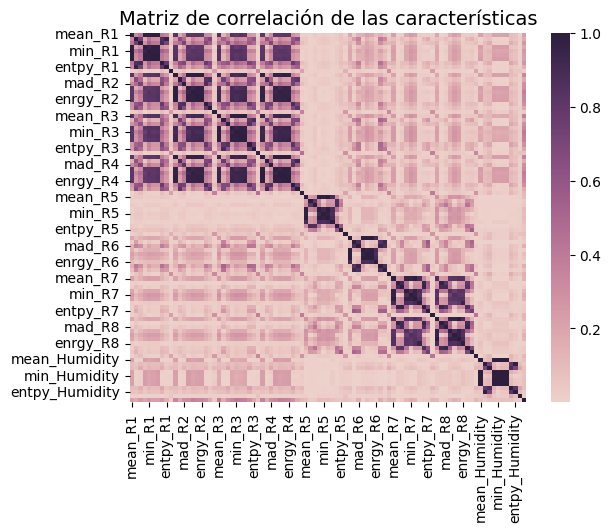

In [ ]:
# correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
# correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la media es lo que hace una clasificación relativamente exitosa (50% de corr con la clase), pero la varianza no ayuda en nada (por debajo de 30% de corr con la clase para las primeras 4 características y caso 0% para el resto). Así que se calcula un nuevo vector de carcaterísticas. Finalmente lo dejé solo con la media y el mismo clasificador que usé al inicio con el 1er vector de carcaterísticas que usé (media y varianza). Ahora lo que queda pendiente es usar otras características para justificar que la media es la mejor.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))
        caracs_list.append('slope_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
      # 'slope': np.polyfit(x, signal, 1)[0]
      data_list.append(np.polyfit(np.arange(128), df_calc, 1)[0]) #Nueva carcaterística, probada hoy (08/07) al final del día

    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_II = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_II, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:18])

df_train.iloc[:,0:18] = scaler.transform(df_train.iloc[:,0:18])
df_val.iloc[:,0:18] = scaler.transform(df_val.iloc[:,0:18])
df_test.iloc[:,0:18] = scaler.transform(df_test.iloc[:,0:18])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  61.976420164108276


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        1.018333           0.0         0.011343             0.0      200   
1        1.047324           0.0         0.010636             0.0      200   
2        0.560614           0.0         0.010375             0.0      200   
3        2.173436           0.0         0.011307             0.0      500   
4        1.967388           0.0         0.010329             0.0      500   
5        1.060306           0.0         0.019062             0.0      500   
6        5.822738           0.0         0.011416             0.0     1000   
7        3.483835           0.0         0.010139             0.0     1000   
8        1.310107           0.0         0.009385             0.0     1000   
9       22.213246           0.0         0.012116             0.0     5000   
10       8.480953           0.0         0.009742             0.0     5000   
11       2.800220           0.0         0.009348             0.0     5000   

    param_degree                    params  split0_test_score  \
0              2   {'C': 200, 'degree': 2}           0.744318   
1              3   {'C': 200, 'degree': 3}           0.770833   
2              4   {'C': 200, 'degree': 4}           0.776515   
3              2   {'C': 500, 'degree': 2}           0.757576   
4              3   {'C': 500, 'degree': 3}           0.765152   
5              4   {'C': 500, 'degree': 4}           0.787879   
6              2  {'C': 1000, 'degree': 2}           0.767045   
7              3  {'C': 1000, 'degree': 3}           0.776515   
8              4  {'C': 1000, 'degree': 4}           0.789773   
9              2  {'C': 5000, 'degree': 2}           0.759470   
10             3  {'C': 5000, 'degree': 3}           0.759470   
11             4  {'C': 5000, 'degree': 4}           0.784091   

    mean_test_score  std_test_score  rank_test_score  
0          0.744318             0.0               12  
1          0.770833             0.0                6  
2          0.776515             0.0                4  
3          0.757576             0.0               11  
4          0.765152             0.0                8  
5          0.787879             0.0                2  
6          0.767045             0.0                7  
7          0.776515             0.0                4  
8          0.789773             0.0                1  
9          0.759470             0.0                9  
10         0.759470             0.0                9  
11         0.784091             0.0                3

Tiempo entrenamiento SVM lineal:  62.27792811393738
Tiempo GridSearch + Entrenamiento = 124.25434827804565


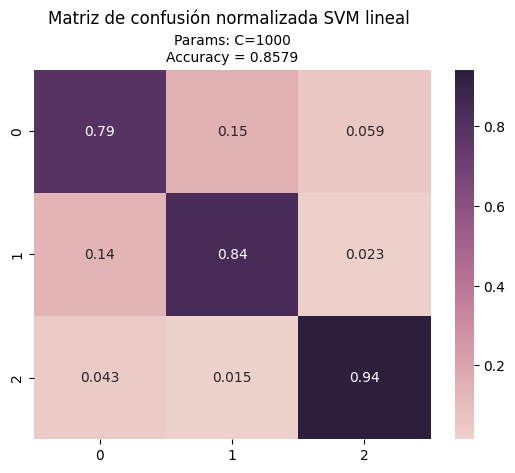

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), decimals=4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

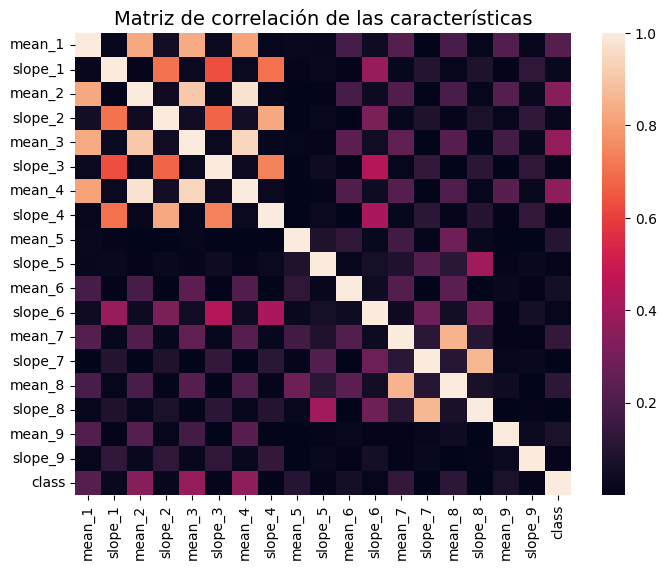

In [ ]:
plt.figure(figsize=(8,6))
correlation_data = df_train_w_class[df_train_w_class['class']==3].corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class[df_train_w_class['class']==3].corr(method='pearson'))

correlation_data = df_train_w_class.corr(method='pearson')
correlation_data_abs_value = abs(df_train_w_class.corr(method='pearson'))
sns.heatmap(correlation_data_abs_value)
plt.title("Matriz de correlación de las características", fontsize=14)
plt.savefig('corr_lineal.svg', format='svg', bbox_inches='tight', pad_inches=0)

Se concluye que la pendiente no tiene una importancia comparable a la de la media en la clasificación de las señales, pero debo sacar el gráfico anterior (matriz de correlación con la clase con las cracterísticas, que sería la media de cada señal) para realmente poder comparar como corresponde y decir porque la pendiente no sirve para clasificar las señales

## Segunda iteración de predicción del conjunto de test

In [ ]:
def test_pred_function(df_te, model):
  y_test_pred = model.predict(df_te)
  with open('pred_test_JE.csv', 'w') as f:
    f.write('Id,Category\n')
    for i in range(len(df_te)):
      f.write(f'{df_te.index[i]},{y_test_pred[i]}\n')

test_pred_function(df_test, best_model)

# III) Cascada de clasificadores
Se clasifica la clase 3 y luego se clasifican las 1 y 2 por separado, del punto anterior se concluyó, con respecto al vecotr de carcaterísticas, que la mejor característica para clasificar la data resultó ser la media, yq eu otras características como la varianza, skew o sma solo mantienen el accuracy o incluso lo disminuyen como sucedió con la varianza, en el primer vector de características se vió que esta carcatrística solo emperoraba el rendimiento general, ya que al quitarla y además aumentar el C, el clasificador pasó de tener un accuracy de validación de 86% a 92%.

In [ ]:
def calculation_feature_vector_2(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 9))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        # 2° it features
        caracs_list.append('mean_' + str(j))
        # caracs_list.append('var_' + str(j))
        # caracs_list.append('min_' + str(j))
        # caracs_list.append('max_' + str(j))
        # caracs_list.append('sma_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      # data_list.append(np.var(df_calc))
      # data_list.append(min(df_calc))
      # data_list.append(max(df_calc))
      # data_list.append(np.ma.average(df_calc))
    # print(i)
    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

In [ ]:
train_val_data_III = calculation_feature_vector_2(df_trainval)
df_test = calculation_feature_vector_2(df_test_no_labels)

In [ ]:
df_train, df_val = train_test_split(train_val_data_III, test_size=0.3, random_state=10, stratify=train_val_data_II['class'])

scaler = StandardScaler().fit(df_train.iloc[:,0:9])

df_train.iloc[:,0:9] = scaler.transform(df_train.iloc[:,0:9])
df_val.iloc[:,0:9] = scaler.transform(df_val.iloc[:,0:9])
df_test.iloc[:,0:9] = scaler.transform(df_test.iloc[:,0:9])

df_train_w_class = df_train.copy()
df_val_w_class = df_val.copy()

y_train = df_train.pop('class')# - 1
y_val = df_val.pop('class')# - 1

In [ ]:
# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear')

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val, y_val)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model.fit(df_train, y_train)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred = best_model.predict(df_val) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  44.57971954345703


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.371135           0.0         0.060842             0.0      200   
1        0.562824           0.0         0.056952             0.0      200   
2        0.904423           0.0         0.056370             0.0      200   
3        0.517559           0.0         0.059153             0.0      500   
4        0.912879           0.0         0.056014             0.0      500   
5        1.604682           0.0         0.051868             0.0      500   
6        0.741986           0.0         0.057042             0.0     1000   
7        2.160672           0.0         0.086544             0.0     1000   
8        2.941602           0.0         0.050041             0.0     1000   
9        2.002565           0.0         0.053482             0.0     5000   
10       3.922843           0.0         0.048200             0.0     5000   
11      12.916391           0.0         0.048186             0.0     5000   

    param_degree                    params  split0_test_score  \
0              2   {'C': 200, 'degree': 2}           0.661616   
1              3   {'C': 200, 'degree': 3}           0.691919   
2              4   {'C': 200, 'degree': 4}           0.718434   
3              2   {'C': 500, 'degree': 2}           0.680556   
4              3   {'C': 500, 'degree': 3}           0.709596   
5              4   {'C': 500, 'degree': 4}           0.744949   
6              2  {'C': 1000, 'degree': 2}           0.688131   
7              3  {'C': 1000, 'degree': 3}           0.718434   
8              4  {'C': 1000, 'degree': 4}           0.766414   
9              2  {'C': 5000, 'degree': 2}           0.717172   
10             3  {'C': 5000, 'degree': 3}           0.773990   
11             4  {'C': 5000, 'degree': 4}           0.775253   

    mean_test_score  std_test_score  rank_test_score  
0          0.661616             0.0               12  
1          0.691919             0.0                9  
2          0.718434             0.0                5  
3          0.680556             0.0               11  
4          0.709596             0.0                8  
5          0.744949             0.0                4  
6          0.688131             0.0               10  
7          0.718434             0.0                5  
8          0.766414             0.0                3  
9          0.717172             0.0                7  
10         0.773990             0.0                2  
11         0.775253             0.0                1

Tiempo entrenamiento SVM lineal:  75.33300042152405
Tiempo GridSearch + Entrenamiento = 119.91271996498108


In [ ]:
# Separación de los datasets
df_val_1_2 = df_val[y_val != 3]         #Estos son los datos que voy a usar para validar el segundo clasificador
df_train_1_2 = df_train[y_train != 3]

y_train_1_2 = y_train[y_train != 3]  #Estas son las clases de los datos que voy a usar para validar el segundo clasificador
y_val_1_2 = y_val[y_val != 3]

df_val_pred_1_2 = df_val[y_pred != 3]    #Estos son los datos que voy a reclasificar, los que fueron predichos como 1 o 2
y_pred_1_2 = y_pred[y_pred != 3]         #Estas son las clases de los datos que voy a reclasificar

# len(df_val_1_2)
# len(y_val_class_1_2)
# len(y_pred_class_1_2) # La dimensión de este array es menor que el conjunto de validación debido a que no contiene todas las observaciónes predichas que realmente tienen las clases 1 o 2. Faltan aquellas que fueron predichas como 3 y que en realidad son de la clase 1 o 2
# len(df_val_pred_class_1_2)
# len(df_val[y_pred == 3])

# print(len(df_val_pred_class_1_2)+len(df_val[y_pred == 3]))
# print(len(df_val))

Permutación predefinida para la validación del modelo

In [ ]:
n_samples = len(y_val_1_2)                                        # Longitud del set de datos de validación, este dato se usará para definir que elementos se usarán para entrenamiento y validación en GridSearchCV()
n_train_grid_search = int(n_samples * 0.7)                    # 80% de los datos utilizdos para entrenamiento
n_val_grid_search = n_samples - n_train_grid_search           # El 20% restante para validación

np.random.seed(42)
indices = np.random.permutation(n_samples)                    # Tomar índices de forma aleatoria
test_fold = np.full(n_samples, -1)                        # Se define el arreglo de los índices de elemntos de train y test

# Asignar 1 a los índices que serán test
test_indices = indices[:n_val_grid_search]
test_fold[test_indices] = 1

ps = PredefinedSplit(test_fold)

In [ ]:
display(df_val_pred_1_2)

mean_R1   mean_R2   mean_R3   mean_R4   mean_R5   mean_R6   mean_R7  \
239   1.096543  0.748626  0.703782  0.742589 -0.153586 -0.538695  0.610996   
7493 -2.436857 -0.862523 -0.915979 -0.824571 -0.319958  0.928797 -0.686096   
6571  0.818759  0.429849  0.442854  0.426695 -0.068313 -1.100757 -0.005982   
6549  0.634276  0.715461  0.701750  0.710410 -0.075733 -1.048698 -0.016646   
6343  1.105231  0.964985  0.942559  0.964935 -0.021235 -0.951169  0.033498   
...        ...       ...       ...       ...       ...       ...       ...   
2530  0.295776 -0.011892 -0.423304  0.187367 -0.223617  0.775180 -0.068628   
943  -0.031109 -0.153198 -1.431315 -0.095407 -0.453486 -1.775178 -0.891543   
5597 -5.223277 -2.959463 -3.278409 -3.124802 -0.594448 -2.977505 -0.939698   
2263 -1.541668 -0.103461 -1.692822 -0.278799 -0.288122 -1.451974 -0.500043   
2105  0.005850  0.507338 -1.742848  0.105865 -0.430276 -0.645179 -0.437328   

       mean_R8  mean_Humidity  
239   0.603499      -0.133996  
7493 -0.684933      -0.857180  
6571 -0.022726      -0.140114  
6549 -0.036925       0.672947  
6343  0.020603      -1.747880  
...        ...            ...  
2530  0.266574       0.097315  
943  -0.767952       0.599935  
5597 -0.956904      -0.664565  
2263 -0.384711      -0.244440  
2105 -0.193695      -0.739110  

[1720 rows x 9 columns]

Segundo clasificador

In [ ]:
# 3° iteración: (Del mismo clasificador que estaba usando antes)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 4° iteración: (Para mejorar la clasificación entre 1 y 2, se penaliza mucho más el error en la clase 1, ya que es la clase que da el accuracy más bajo)
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale', class_weight={1: 2, 2: 1})

# 4° a) iteración:
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'class_weight': [
#         {1: 1, 2: 1},     # Sin penalización
#         {1: 1, 2: 3},     # Penaliza más errores en clase 2
#         {1: 3, 2: 1},     # Penaliza más errores en clase 1
#         'balanced'        # Automático según la distribución de clases
#     ]}

# 4° b) iteración: 10/07
parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10], 'class_weight': [
        {1: 1, 2: 1},     # Sin penalización
        {1: 1, 2: 3},     # Penaliza más errores en clase 2
        {1: 3, 2: 1},     # Penaliza más errores en clase 1
        'balanced'        # Automático según la distribución de clases
    ]}

# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
svc = svm.SVC()

clf = GridSearchCV(svc, parameters, cv=ps)

# GridSearch
t0 = time.time()
clf.fit(df_val_1_2, y_val_1_2)
t = time.time()
tiempo_svm_lin_grid_search = t - t0
print('Tiempo GridSearch SVM lineal: ',tiempo_svm_lin_grid_search)

display(pd.DataFrame(clf.cv_results_)) # Resultados del GridSearchCV()

best_model_2 = clf.best_estimator_ # Se extraen los mejores hiperparámetros calculados a través de GridSearchCV()
# svc_lin = svm.SVC(kernel='linear', C=best_model.C)# Se define un nuevo SVM con los mejores hiperparámetros

# Entrenamiento del SVM lineal con el conjunto de entrenamiento
t0 = time.time()
best_model_2.fit(df_train_1_2, y_train_1_2)
t = time.time()
tiempo_svm_lin_training = t - t0
print('Tiempo entrenamiento SVM lineal: ',tiempo_svm_lin_training)

print('Tiempo GridSearch + Entrenamiento =',tiempo_svm_lin_grid_search+tiempo_svm_lin_training)
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  4.674489498138428


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.104946           0.0         0.065760             0.0        1   
1        0.097726           0.0         0.060798             0.0        1   
2        0.088228           0.0         0.054423             0.0        1   
3        0.076679           0.0         0.041393             0.0        1   
4        0.062845           0.0         0.025764             0.0        1   
5        0.056964           0.0         0.026925             0.0        1   
6        0.054104           0.0         0.023991             0.0        1   
7        0.050900           0.0         0.026216             0.0        1   
8        0.052837           0.0         0.026384             0.0        1   
9        0.053609           0.0         0.025751             0.0        1   
10       0.049143           0.0         0.025695             0.0        1   
11       0.048201           0.0         0.023937             0.0        1   
12       0.071911           0.0         0.035133             0.0        1   
13       0.060905           0.0         0.030935             0.0        1   
14       0.055664           0.0         0.028397             0.0        1   
15       0.051779           0.0         0.025234             0.0        1   
16       0.069543           0.0         0.031099             0.0       10   
17       0.056419           0.0         0.027819             0.0       10   
18       0.054179           0.0         0.022937             0.0       10   
19       0.049965           0.0         0.020853             0.0       10   
20       0.062573           0.0         0.025634             0.0       10   
21       0.062890           0.0         0.026731             0.0       10   
22       0.062671           0.0         0.020916             0.0       10   
23       0.049740           0.0         0.020907             0.0       10   
24       0.060138           0.0         0.025853             0.0       10   
25       0.058615           0.0         0.025475             0.0       10   
26       0.056904           0.0         0.021795             0.0       10   
27       0.050182           0.0         0.018721             0.0       10   
28       0.074332           0.0         0.037021             0.0       10   
29       0.064099           0.0         0.027647             0.0       10   
30       0.054417           0.0         0.022774             0.0       10   
31       0.050460           0.0         0.019233             0.0       10   
32       0.057755           0.0         0.028947             0.0      100   
33       0.075821           0.0         0.025143             0.0      100   
34       0.092710           0.0         0.018401             0.0      100   
35       0.058577           0.0         0.017836             0.0      100   
36       0.071654           0.0         0.025353             0.0      100   
37       0.098546           0.0         0.022310             0.0      100   
38       0.115492           0.0         0.017597             0.0      100   
39       0.073479           0.0         0.019342             0.0      100   
40       0.071030           0.0         0.028701             0.0      100   
41       0.090554           0.0         0.025855             0.0      100   
42       0.109324           0.0         0.017712             0.0      100   
43       0.060600           0.0         0.021118             0.0      100   
44       0.065515           0.0         0.028913             0.0      100   
45       0.076946           0.0         0.025851             0.0      100   
46       0.088212           0.0         0.018625             0.0      100   
47       0.059689           0.0         0.017956             0.0      100   

   param_class_weight  param_gamma param_kernel  \
0        {1: 1, 2: 1}     0.001268          rbf   
1        {1: 1, 2: 1}     0.012684          rbf   
2        {1: 1, 2: 1}     0.126839          rbf   
3        {1: 1, 2: 1}     

Tiempo entrenamiento SVM lineal:  0.47613072395324707
Tiempo GridSearch + Entrenamiento = 5.150620222091675


In [ ]:
y_pred_1_2 = best_model_2.predict(df_val_pred_1_2) # Predicción del conjunto de validación

In [ ]:
# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_pred_final = y_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_pred_final[mask_1_2] = y_pred_1_2

In [ ]:
y_pred_final

array([1., 3., 2., ..., 2., 2., 3.])

              precision    recall  f1-score   support

         1.0       0.95      0.90      0.92       879
         2.0       0.95      0.96      0.95       880
         3.0       0.95      0.99      0.97       880

    accuracy                           0.95      2639
   macro avg       0.95      0.95      0.95      2639
weighted avg       0.95      0.95      0.95      2639



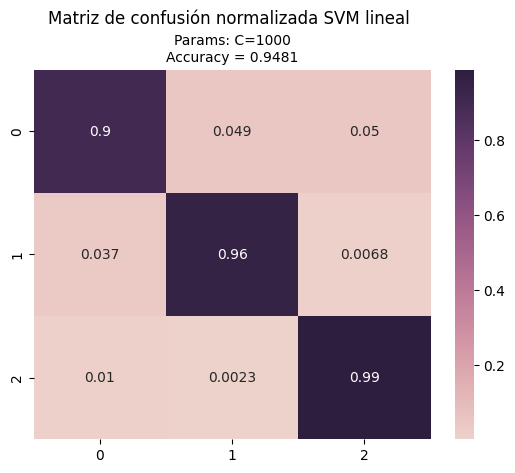

In [ ]:
# y_class_1_2 = y_val[y_val != 3]
print(classification_report(y_val, y_pred_final))

accu_score = accuracy_score(y_val, y_pred_final)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred_final, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)


plt.show()

Se concluye que la clasificación en cascada no mejoró la clasificación global, de manera que se vuelve a este punto inicial, penalizando mucho más el error en la clase 1 para mejorar la clasificación entre 1 y 2

Se calcula la tercera predicción del conjunto de test, esta vez con el clasificador en cascada

In [ ]:
y_test_pred = best_model.predict(df_test)

In [ ]:
print(best_model.classes_)
best_model_2.classes_
print("Shape de clases:", best_model.classes_.shape)

[1. 2. 3.]
Shape de clases: (3,)


In [ ]:
y_pred_1_2 = best_model_2.predict(df_test) # Predicción del conjunto de validación

y_test_pred_1_2 = y_test_pred[y_test_pred != 3]

# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
mask_1_2 = y_test_pred != 3  # boolean array del mismo largo que y_pred

# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_test_pred_final = y_test_pred.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_test_pred_final[mask_1_2] = y_test_pred_1_2

with open('pred_test.csv', 'w') as f:
  f.write('Id,Category\n')
  for i in range(len(df_test)):
    f.write(f'{df_test.index[i]},{int(y_test_pred_final[i])}\n')

# test_pred_function(df_test, best_model)

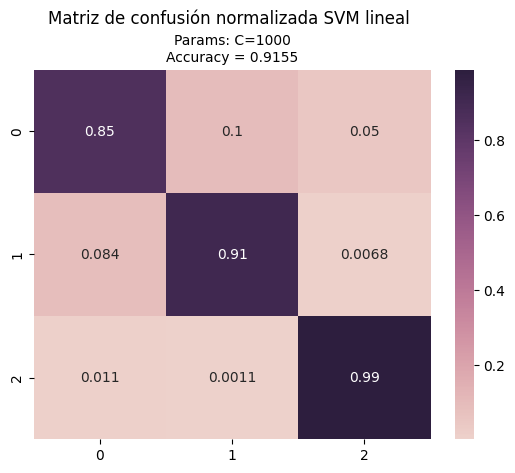

In [ ]:
accu_score = accuracy_score(y_val, y_pred)
plt.title(f'Params: C={best_model.C}\nAccuracy = {accu_score:.4f}', fontsize = 10)
sns.heatmap(np.round(confusion_matrix(y_val, y_pred, normalize='true'), 4), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.suptitle('Matriz de confusión normalizada SVM lineal', x=0.43, y=1.005)
# for text in disp_norm.text_.ravel():
#     text.set_fontsize(14) # Ajusta fontsize
plt.savefig('conf_mat_svm.svg')

plt.show()

In [ ]:
print("Clases en y_val:", np.unique(y_val))
print("Clases en y_pred:", np.unique(y_pred))

Clases en y_val: [1 2 3]
Clases en y_pred: [1 2 3]


# Borrador

#### Borrador de las celdas para conseguir el mejor SVM

In [ ]:
ps = predefined_split(y_val)

# 1° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100]}
# svc = svm.SVC(kernel='linear') #decision_function_shape{‘ovo’, ‘ovr’}, default=’ovr’

# 2° iteración:
# parameters = {'C':[0.1, 1, 10], 'degree':[2,3,4]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[0.1, 1, 10, 100, 200], 'degree':[2,3,4]}
# parameters = {'C':[0.1, 1, 10, 100, 1000], 'degree':[2,3,4],'kernel':['poly']}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 2° a) iteración:
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4]}
# parameters = {'C':[100, 200, 500, 1000], 'degree':[2,3,4], 'kernel':['poly']}
# parameters = {'C':[200, 500, 1000, 5000], 'degree':[2,3,4], 'coef0':[-5, -1, 1, 5]}
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]}
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
# parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='poly', coef0=1)

# svc = svm.SVC(kernel='poly', gamma='scale')
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')

# 3° iteración:
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'degree':[2,3,4], 'coef0':[-1, 1]}
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly'], 'degree':[2,3,4], 'coef0':[-1, 1]} #Probado el 10/07, debo definir el kernel dentro de los parámetros
# svc = svm.SVC(kernel='poly', gamma='scale')
# Poco viable por el timepo de entrenamiento que toma

# 4° iteración:
# parameters = {'kernel':['rbf'],'C':[0.01, 0.1, 1, 10, 100],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'kernel':['rbf'],'C':[1, 10, 100, 1000, 2000],'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# svc = svm.SVC(kernel='rbf')

# 5° iteración: (09/07) Selección del kernel mediante el GridSearch
# parameters = {'C':[0.01, 0.1, 1, 10, 100], 'kernel':['poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[100, 200, 500, 1000, 2000],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']}  #--------> Para probar el mejor kernel
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['linear', 'poly', 'rbf', 'sigmoid']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch
# parameters = {'C':[0.1, 1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*100]}
# parameters = {'C':[1, 10, 100, 200], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} #Probado el 10/07
# parameters = {'C':[1, 10, 100], 'kernel':['rbf'], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10]} # Pruebo este vector el 10/07 para verificar el clasificador con el nuevo vector de características y de esta forma evaluar el tiempo de cálculo y el nuevo vector
# parameters = {'C':[0.01, 0.1, 1, 10, 100],'kernel':['sigmoid','poly', 'rbf']} #Al tener como resultado el mayor C, se plantea un nuevo conjunto de valores C para el GridSearch

best_model = make_clf(svc, parameters, df_train, y_train, df_val, y_val)
# best_model = make_clf(parameters, df_train.iloc[:,0:44], y_train, df_val.iloc[:,0:44], y_val)

y_pred = best_model.predict(df_val) # Predicción del conjunto de validación
# y_pred = best_model.predict(df_val.iloc[:,0:44]) # Predicción del conjunto de validación

Tiempo GridSearch SVM lineal:  129.43655729293823


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        1.059953           0.0         0.025252             0.0      200   
1        1.968902           0.0         0.026243             0.0      200   
2        2.271038           0.0         0.017093             0.0      200   
3        3.453155           0.0         0.025424             0.0      200   
4        2.511131           0.0         0.023767             0.0      500   
5        6.270993           0.0         0.026727             0.0      500   
6        4.300199           0.0         0.026990             0.0      500   
7        3.811153           0.0         0.015512             0.0      500   
8        5.232903           0.0         0.023627             0.0     1000   
9       19.762902           0.0         0.019646             0.0     1000   
10       6.963032           0.0         0.014892             0.0     1000   
11       5.220491           0.0         0.013615             0.0     1000   
12      14.192465           0.0         0.026597             0.0     2000   
13      24.415898           0.0         0.017933             0.0     2000   
14      14.488064           0.0         0.014944             0.0     2000   
15       4.374546           0.0         0.012971             0.0     2000   

    param_degree                    params  split0_test_score  \
0              2   {'C': 200, 'degree': 2}           0.785354   
1              3   {'C': 200, 'degree': 3}           0.835859   
2              4   {'C': 200, 'degree': 4}           0.854798   
3              5   {'C': 200, 'degree': 5}           0.891414   
4              2   {'C': 500, 'degree': 2}           0.796717   
5              3   {'C': 500, 'degree': 3}           0.833333   
6              4   {'C': 500, 'degree': 4}           0.866162   
7              5   {'C': 500, 'degree': 5}           0.883838   
8              2  {'C': 1000, 'degree': 2}           0.789141   
9              3  {'C': 1000, 'degree': 3}           0.849747   
10             4  {'C': 1000, 'degree': 4}           0.886364   
11             5  {'C': 1000, 'degree': 5}           0.897727   
12             2  {'C': 2000, 'degree': 2}           0.785354   
13             3  {'C': 2000, 'degree': 3}           0.842172   
14             4  {'C': 2000, 'degree': 4}           0.877525   
15             5  {'C': 2000, 'degree': 5}           0.897727   

    mean_test_score  std_test_score  rank_test_score  
0          0.785354             0.0               15  
1          0.835859             0.0               11  
2          0.854798             0.0                8  
3          0.891414             0.0                3  
4          0.796717             0.0               13  
5          0.833333             0.0               12  
6          0.866162             0.0                7  
7          0.883838             0.0                5  
8          0.789141             0.0               14  
9          0.849747             0.0                9  
10         0.886364             0.0                4  
11         0.897727             0.0                1  
12         0.785354             0.0               15  
13         0.842172             0.0               10  
14         0.877525             0.0                6  
15         0.897727             0.0                1

Tiempo entrenamiento SVM lineal:  33.46855592727661
Tiempo GridSearch + Entrenamiento = 162.90511322021484


In [ ]:
def calculation_feature_vector(df_data):

  caracs_list = []

  big_data_arr = np.zeros((len(df_data), 18))

  for i in range(0, len(df_data)):
  # for i in range(0, 2):
    data_list = []

    for j in range(1,10):

      if j == 9:
        df_calc = df_data.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
      else:
        df_calc = df_data.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

      if i == 0:
        caracs_list.append('mean_' + str(j))
        caracs_list.append('var_' + str(j))
        caracs_list.append('mad_' + str(j)) # Desde aquí es el nuevo vector de carcaterísticas que debería haber probado desde un principio
        caracs_list.append('max_' + str(j))

        caracs_list.append('min_' + str(j))
        caracs_list.append('sma_' + str(j))
        caracs_list.append('enrgy_' + str(j))
        caracs_list.append('iqr_' + str(j))

        caracs_list.append('entpy_' + str(j))
        caracs_list.append('arCoeff_' + str(j))
        caracs_list.append('corr_' + str(j))

        df = pd.DataFrame(columns=caracs_list)

      data_list.append(np.mean(df_calc))
      data_list.append(np.var(df_calc))
      data_list.append(np.median(np.abs(df_calc - np.median(df_calc))))
      data_list.append(np.max(df_calc))

      data_list.append(np.min(df_calc))
      data_list.append(np.sum(np.abs(df_calc)))
      data_list.append(np.sum(df_calc**2)/len(df_calc))
      data_list.append(sp.stats.iqr(df_calc))

      data_list.append(sp.stats.entropy(df_calc))
      data_list.append(arr_coef) # No sé como implementar esto en python pero puedes dejarlo en este formato para cuando descubra la librería que permite calcular esta característica
      data_list.append(np.corrcoef(df_calc[:-1], df_calc[1:])[0][1])


    big_data_arr[i,:] = np.array(data_list)

  df = pd.DataFrame(big_data_arr, columns=caracs_list)

  if 'class' in df_data.columns:
    df = pd.concat([df, df_data['class']], axis=1)

  return df

Se organizan los datos en un array de la forma i,j,k, se hace esto para facilitar la programación del cálculo de características

In [ ]:
array_train_val = np.zeros((len(df_trainval), 9, 128)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

k = array_train_val.shape[-1]

for i in range(array_train_val.shape[0]):

  for j in range(array_train_val.shape[1]):

    array_train_val[i,j,:] = np.array(df_trainval.loc[i][j*k : k + j*k])

In [ ]:
print(array_train_val[0,0,:].shape)
np.array(df_trainval.loc[0][2*128 : 128 + 2*128]).shape

(128,)


(128,)

In [ ]:
train_val_caracs = pd.DataFrame()
# np.zeros((len(df_trainval), 18)) # Matriz -> n° de muestras X n° de sensores X tamaño de la ventana  ->  [8795, 8, 127]

column_names_caracs = []

for i in range(array_train_val.shape[0]):
  means = []
  variances = []

  print(i)

  for j in range(array_train_val.shape[1]):

    means.append(np.mean(array_train_val[i,j,:]))
    variances.append(np.var(array_train_val[i,j,:]))

    if i == 0:
      column_names_caracs.append('mean_' + str(j+1))
      column_names_caracs.append('vars_' + str(j+1))

  display(pd.DataFrame(means).concat(pd.DataFrame(variances)))


  # train_val_caracs = train_val_caracs.append(pd.Series(means + variances), ignore_index=True)

# train_val_caracs

NameError: name 'array_train_val' is not defined

In [ ]:
df_trainval_caracs = pd.DataFrame(array_train_caracs, columns=column_names_caracs)
df_trainval_caracs
# array_train_val[0,0,:]

mean_1     mean_2     mean_3     mean_4     mean_5     mean_6  \
0     12.754292  10.025339  10.148645  11.289939  11.385055  18.354793   
1     11.967599   8.068474   8.285822   7.607900  11.844489  16.910116   
2     10.874177   6.733694   4.255943   8.015534  14.331759  14.787651   
3     12.554823   9.927928  10.074674  11.206576  10.498980  16.661062   
4      8.396118   5.376859   3.503016   6.654920   5.419658  14.696602   
...         ...        ...        ...        ...        ...        ...   
8791  12.412083   9.383410   9.548767  10.667314  10.898194  18.001598   
8792  12.834633   9.708894   9.818239  10.988033  19.437108  17.201457   
8793  11.981392   9.590782   9.755056  11.072576  10.708553  16.235656   
8794  12.913830  10.145803  10.285827  11.450341  11.323898  17.286553   
8795  12.240178   9.772667   9.950347  11.349563  12.636113  16.568924   

        mean_7    mean_8     mean_9  
0     4.825439  5.305171  60.131052  
1     2.535805  3.026097  65.021354  
2     1.883080  2.149658  56.372610  
3     7.049197  7.333878  64.552841  
4     2.338161  2.889587  58.124579  
...        ...       ...        ...  
8791  5.556913  6.264065  50.446031  
8792  6.097525  6.517089  53.291634  
8793  6.379035  7.499586  67.555945  
8794  6.387599  6.876442  52.303113  
8795  6.814079  6.311041  56.962474  

[8796 rows x 9 columns]

In [ ]:
caracs_list = []

big_data_arr = np.zeros((len(df_trainval), 18))

for i in range(0, len(df_trainval)):
  data_list = []

  for j in range(1,10):

    if j == 9:
      df_calc = df_trainval.loc[i, f'Humidity_0':f'Humidity_127'] #display(df_trainval.loc[i, f'Humidity_0':f'Humidity_127'])
    else:
      df_calc = df_trainval.loc[i, f'R{j}_0':f'R{j}_127'] #display(df_trainval.loc[i, f'R{j}_0':f'R{j}_127'])

    if i == 0:
      caracs_list.append('mean_' + str(j))
      caracs_list.append('var_' + str(j))

      df_train_val = pd.DataFrame(columns=caracs_list)

    data_list.append(np.mean(df_calc))
    data_list.append(np.var(df_calc))

  big_data_arr[i,:] = np.array(data_list)

df_train_val = pd.DataFrame(big_data_arr, columns=caracs_list)
df_train_val = pd.concat([df_train_val, df_trainval['class']], axis=1)
df_train_val
# display(array_train_caracs)
# print(big_data_arr)

mean_1         var_1     mean_2         var_2     mean_3  \
0     12.754292  1.906951e-04  10.025339  2.522271e-03  10.148645   
1     11.967599  4.615858e-02   8.068474  1.747379e-01   8.285822   
2     10.874177  1.686482e-04   6.733694  8.399944e-03   4.255943   
3     12.554823  9.594409e-06   9.927928  1.547504e-06  10.074674   
4      8.396118  1.375398e-01   5.376859  1.803704e-01   3.503016   
...         ...           ...        ...           ...        ...   
8791  12.412083  2.465645e-04   9.383410  1.878341e-04   9.548767   
8792  12.834633  4.851733e-07   9.708894  6.730447e-07   9.818239   
8793  11.981392  1.075543e-04   9.590782  4.493687e-05   9.755056   
8794  12.913830  2.502985e-04  10.145803  5.793843e-05  10.285827   
8795  12.240178  6.741843e-05   9.772667  5.011188e-04   9.950347   

             var_3     mean_4     var_4     mean_5         var_5     mean_6  \
0     1.373784e-03  11.289939  0.002741  11.385055  3.019404e-03  18.354793   
1     1.192520e-01   7.607900  0.037851  11.844489  6.111635e-04  16.910116   
2     7.255871e-02   8.015534  0.014101  14.331759  4.511163e-05  14.787651   
3     5.384760e-07  11.206576  0.000003  10.498980  5.700092e-07  16.661062   
4     2.255354e-01   6.654920  0.032712   5.419658  3.459920e-02  14.696602   
...            ...        ...       ...        ...           ...        ...   
8791  3.238135e-04  10.667314  0.000181  10.898194  7.399777e-05  18.001598   
8792  2.962567e-06  10.988033  0.000012  19.437108  3.249446e-04  17.201457   
8793  3.997650e-05  11.072576  0.000064  10.708553  3.387687e-05  16.235656   
8794  7.715424e-06  11.450341  0.000036  11.323898  2.544722e-03  17.286553   
8795  5.166442e-04  11.349563  0.000572  12.636113  1.707788e-04  16.568924   

         var_6    mean_7         var_7    mean_8         var_8     mean_9  \
0     0.000251  4.825439  1.891078e-04  5.305171  2.026727e-04  60.131052   
1     0.052403  2.535805  7.630309e-03  3.026097  3.469361e-02  65.021354   
2     0.020747  1.883080  1.527344e-03  2.149658  1.502168e-03  56.372610   
3     0.000034  7.049197  1.462127e-07  7.333878  5.272732e-08  64.552841   
4     1.606592  2.338161  7.527932e-03  2.889587  8.011927e-03  58.124579   
...        ...       ...           ...       ...           ...        ...   
8791  0.000071  5.556913  3.080433e-05  6.264065  1.567876e-05  50.446031   
8792  0.000003  6.097525  4.279667e-06  6.517089  1.666033e-06  53.291634   
8793  0.000048  6.379035  6.832402e-06  7.499586  5.392002e-05  67.555945   
8794  0.001164  6.387599  3.191764e-05  6.876442  5.058336e-05  52.303113   
8795  0.000086  6.814079  5.591631e-05  6.311041  3.329563e-05  56.962474   

         var_9  class  
0     0.004940      1  
1     0.012975      1  
2     0.005181      1  
3     0.000700      1  
4     0.052991      1  
...        ...    ...  
8791  0.129468      3  
8792  0.000174      3  
8793  0.029843      3  
8794  0.003369      3  
8795  0.015532      3  

[8796 rows x 19 columns]

# Borrador

In [ ]:
#Esto debe ir desde la nueva selección de características al momento de reducir el vector
N_derv = 1
plt.figure()
plt.grid()
plt.xlabel('Index')
plt.ylabel('Derivative de Magnitud medida')
plt.title(f'Signals of R{start+1}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_1)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_2)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

filename = f'grad_of_signals_R{start}.svg'
filepath = os.path.join(folder, filename)
plt.savefig(filepath)


N_derv = 2
plt.figure()
plt.grid()
plt.xlabel('Index')
plt.ylabel('Segunda derivada de Magnitud medida')
plt.title(f'Signals of R{start+1}')

for i in range(num_sign_per_graph):
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==1].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_1)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==2].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_2)
  plt.plot(np.arange(0,128), np.gradient(df_trainval[df_trainval['class']==3].sample(n=num_sign_per_graph, random_state=rs).iloc[i][idx[0]:idx[1]],edge_order=N_derv), **plot_kwargs_3)
  if i == 0:
    plt.legend(loc=8, bbox_to_anchor=(0.5, -0.25), ncol=3)
plt.show()

#### EL MEJOR RESULTADO EN TEST
REDUCCIÓN DEL VECTOR DE CARACTERÍSTICAS (SOLO LAS MEDIAS) Y NUEVO POLY

In [ ]:
df_train

mean_R1    var_R1    mad_R1    max_R1    min_R1    ran_R1    sma_R1  \
5693  0.526979 -0.158350 -0.272628  0.504717  0.539609 -0.340592  0.526979   
2435  0.205834 -0.158279 -0.282334  0.160054  0.244177 -0.330449  0.205834   
67    0.695675 -0.157622 -0.245588  0.694801  0.690926 -0.310816  0.695675   
7082  1.087978 -0.158812 -0.337107  1.101093  1.062662 -0.394255  1.087978   
5029 -0.162365 -0.150788 -0.032739 -0.194373 -0.113803 -0.155062 -0.162365   
...        ...       ...       ...       ...       ...       ...       ...   
2387  0.814096 -0.158413 -0.330173  0.814381  0.808497 -0.360225  0.814096   
5723 -0.611347 -0.036459 -0.083352 -0.658869 -0.950557  1.194040 -0.611347   
8741  0.607134 -0.158432 -0.321160  0.589297  0.611721 -0.341901  0.607134   
1939  0.709671 -0.153167 -0.120098  0.730181  0.679749 -0.185493  0.709671   
114  -3.199986  0.206121  0.468392 -3.065816 -3.017726  1.277119 -3.199986   

      enrgy_R1    iqr_R1  entpy_R1  ...  mad_Humidity  max_Humidity  \
5693  0.542611 -0.304642  0.136466  ...     -0.447712      0.078780   
2435  0.186040 -0.303655  0.136414  ...     -0.120137      0.479461   
67    0.733042 -0.257287  0.136079  ...      0.015618      0.306252   
7082  1.184198 -0.358198  0.136722  ...     -0.578261     -1.045566   
5029 -0.213154 -0.151443  0.131849  ...     -0.005205      1.916024   
...        ...       ...       ...  ...           ...           ...   
2387  0.868001 -0.299568  0.136510  ...     -0.382036     -0.943312   
5723 -0.685662 -0.077733  0.056907  ...     -0.525400      1.153480   
8741  0.632824 -0.306474  0.136514  ...     -0.367620     -0.621799   
1939  0.748955 -0.184000  0.133680  ...      0.525001      1.389206   
114  -3.114349  1.082402 -0.220694  ...      0.949887     -1.046056   

      min_Humidity  ran_Humidity  sma_Humidity  enrgy_Humidity  iqr_Humidity  \
5693      0.124418     -0.395919      0.095731        0.052556     -0.348864   
2435      0.509377     -0.207917      0.495414        0.452429     -0.178888   
67        0.222429      0.781580      0.276988        0.232366      0.517356   
7082     -0.977820     -0.727959     -1.012109       -0.987019     -0.619577   
5029      1.834080      0.959097      1.868859        1.926918      0.102325   
...            ...           ...           ...             ...           ...   
2387     -0.900310     -0.495807     -0.924456       -0.908446     -0.389838   
5723      1.080293      0.789306      1.048309        1.027308     -0.482760   
8741     -0.601641     -0.254089     -0.614478       -0.625517     -0.286021   
1939      1.426694     -0.165423      1.407064        1.413756      0.190905   
114      -1.116914      0.503255     -1.090841       -1.056953      0.626778   

      entpy_Humidity  arCoeff_Humidity  corr_Humidity  
5693        0.211472          0.757430       0.703104  
2435        0.198444         -0.414175      -0.464410  
67         -0.056046          0.258798       0.322598  
7082        0.239313         -0.462535      -0.893262  
5029       -0.013669          0.087250       0.496174  
...              ...               ...            ...  
2387        0.221490         -0.280392      -0.299979  
5723        0.118492         -1.172359       0.911826  
8741        0.211301          1.054066       0.650232  
1939        0.167598          0.638429       0.797557  
114        -0.100179          0.269744       0.356415  

[6157 rows x 108 columns]

Tiempo GridSearch SVM lineal:  108.54535174369812


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0        0.103924           0.0         0.030709             0.0        1   
1        0.121941           0.0         0.026732             0.0        1   
2        0.146642           0.0         0.025613             0.0        1   
3        0.191453           0.0         0.023500             0.0        1   
4        0.184476           0.0         0.027030             0.0       10   
5        0.219987           0.0         0.023480             0.0       10   
6        0.371031           0.0         0.021347             0.0       10   
7        0.380248           0.0         0.019577             0.0       10   
8        0.670309           0.0         0.024652             0.0      100   
9        2.140335           0.0         0.035702             0.0      100   
10       1.692304           0.0         0.018553             0.0      100   
11       1.110093           0.0         0.016176             0.0      100   
12       5.169593           0.0         0.023652             0.0     1000   
13      19.595181           0.0         0.018472             0.0     1000   
14       5.986939           0.0         0.014932             0.0     1000   
15       4.349910           0.0         0.021950             0.0     1000   
16      14.916665           0.0         0.023867             0.0     2000   
17      22.221155           0.0         0.017519             0.0     2000   
18      15.337355           0.0         0.024723             0.0     2000   
19       4.643230           0.0         0.013822             0.0     2000   

    param_degree                    params  split0_test_score  \
0              2     {'C': 1, 'degree': 2}           0.731061   
1              3     {'C': 1, 'degree': 3}           0.770202   
2              4     {'C': 1, 'degree': 4}           0.777778   
3              5     {'C': 1, 'degree': 5}           0.795455   
4              2    {'C': 10, 'degree': 2}           0.775253   
5              3    {'C': 10, 'degree': 3}           0.797980   
6              4    {'C': 10, 'degree': 4}           0.819444   
7              5    {'C': 10, 'degree': 5}           0.819444   
8              2   {'C': 100, 'degree': 2}           0.782828   
9              3   {'C': 100, 'degree': 3}           0.823232   
10             4   {'C': 100, 'degree': 4}           0.849747   
11             5   {'C': 100, 'degree': 5}           0.875000   
12             2  {'C': 1000, 'degree': 2}           0.789141   
13             3  {'C': 1000, 'degree': 3}           0.849747   
14             4  {'C': 1000, 'degree': 4}           0.886364   
15             5  {'C': 1000, 'degree': 5}           0.897727   
16             2  {'C': 2000, 'degree': 2}           0.785354   
17             3  {'C': 2000, 'degree': 3}           0.842172   
18             4  {'C': 2000, 'degree': 4}           0.877525   
19             5  {'C': 2000, 'degree': 5}           0.897727   

    mean_test_score  std_test_score  rank_test_score  
0          0.731061             0.0               20  
1          0.770202             0.0               19  
2          0.777778             0.0               17  
3          0.795455             0.0               13  
4          0.775253             0.0               18  
5          0.797980             0.0               12  
6          0.819444             0.0               10  
7          0.819444             0.0               10  
8          0.782828             0.0               16  
9          0.823232             0.0                9  
10         0.849747             0.0                6  
11         0.875000             0.0                5  
12         0.789141             0.0               14  
13         0.849747             0.0                6  
14         0.886364             0.0                3  
15         0.897727             0.0                1  
16         0.785354             0.0               15  
17         0.842172           

Tiempo entrenamiento SVM lineal:  32.13842153549194
Tiempo GridSearch + Entrenamiento = 140.68377327919006


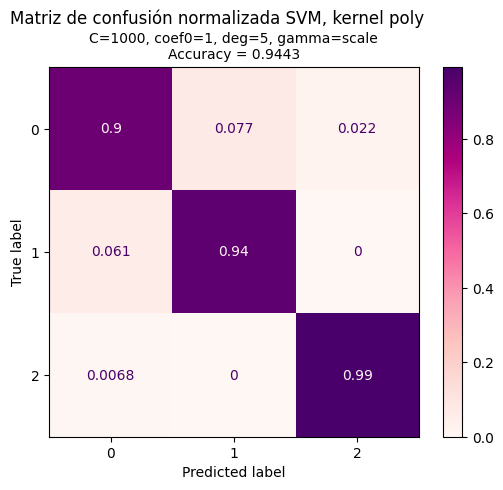

In [ ]:
# parameters = {'C':[200, 500, 1000, 2000], 'degree':[2,3,4,5]} # C PROBADOS DE FORMA EMPÍRICA
parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
best_model = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val) # Solo las medias de las mediciones de cada sensor (EMPÍRICO)

y_pred = best_model.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

#### Ahora si probamos con el kernel lineal de nuevo??

Tiempo GridSearch SVM lineal:  1.991894006729126


mean_fit_time  std_fit_time  mean_score_time  std_score_time  param_C  \
0       0.172627           0.0         0.033377             0.0        1   
1       0.206281           0.0         0.033055             0.0        2   
2       0.328967           0.0         0.034101             0.0        5   
3       0.449628           0.0         0.032308             0.0       10   

      params  split0_test_score  mean_test_score  std_test_score  \
0   {'C': 1}           0.633838         0.633838             0.0   
1   {'C': 2}           0.637626         0.637626             0.0   
2   {'C': 5}           0.641414         0.641414             0.0   
3  {'C': 10}           0.640152         0.640152             0.0   

   rank_test_score  
0                4  
1                3  
2                1  
3                2

Tiempo entrenamiento SVM lineal:  5.107477903366089
Tiempo GridSearch + Entrenamiento = 7.099371910095215


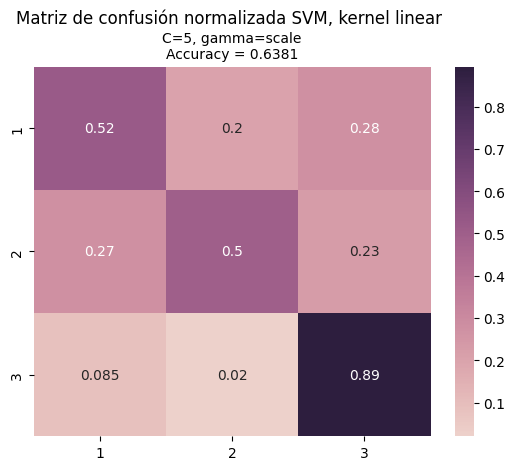

In [ ]:
parameters = {'C':[1, 2, 5, 10]}
svc = svm.SVC(kernel='linear')
best_model = make_clf(svc, parameters, df_train[[col for col in df_train.columns if col.startswith('mean_')]], y_train, df_val[[col for col in df_val.columns if col.startswith('mean_')]], y_val)

y_pred = best_model.predict(df_val[[col for col in df_val.columns if col.startswith('mean_')]]) # Predicción del conjunto de validación

conf_mat(best_model, y_val, y_pred)

### Reclasificador en cascada, toma los valores clasificados como 1 o 2 y los vuelve a pasar por un SVM (No sirve)

In [ ]:
# Separación de los datasets
df_val_1_2 = df_val_filter[y_val != 3]         #Estos son los datos que voy a usar para validar el segundo clasificador
df_train_1_2 = df_train_filter[y_train != 3]

y_train_1_2 = y_train[y_train != 3]  #Estas son las clases de los datos que voy a usar para validar el segundo clasificador
y_val_1_2 = y_val[y_val != 3]

df_val_pred_1_2 = df_val_filter[y_pred_filter != 3]    #Estos son los datos que voy a reclasificar, los que fueron predichos como 1 o 2
y_pred_1_2 = y_pred_filter[y_pred_filter != 3]         #Estas son las clases de los datos que voy a reclasificar

In [ ]:
mask_1_2 = (y_pred_filter == 1) | (y_pred_filter == 2)


In [ ]:
df_val_pred_1_2

mean_R1    var_R1    mad_R1    min_R1    ran_R1    sma_R1  enrgy_R1  \
239   1.096543 -0.158607 -0.304521  1.066853 -0.364152  1.096543  1.194178   
5350  0.514111 -0.156605 -0.192896  0.520910 -0.294782  0.514111  0.528180   
7493 -2.436857 -0.158313 -0.267081 -2.173449 -0.340265 -2.436857 -2.452145   
6571  0.818759 -0.158171 -0.240735  0.808927 -0.351063  0.818759  0.873338   
6549  0.634276 -0.158563 -0.326707  0.644714 -0.358589  0.634276  0.663481   
...        ...       ...       ...       ...       ...       ...       ...   
2530  0.295776 -0.116197  0.361759  0.228701  0.190475  0.295776  0.285280   
943  -0.031109 -0.137036 -0.156150  0.004843  0.115216 -0.031109 -0.071961   
5597 -5.223277  4.343969  1.097718 -5.646002  4.955066 -5.223277 -4.644852   
2263 -1.541668 -0.109294  0.395039 -1.442766  0.199310 -1.541668 -1.617419   
2105  0.005850 -0.083495  0.563515 -0.062325  0.366189  0.005850 -0.031779   

        iqr_R1   mean_R2    var_R2  ...    sma_R4  enrgy_R4    iqr_R4  \
239  -0.319017  0.748626 -0.164941  ...  0.742589  0.783413 -0.319538   
5350 -0.226845  0.366458 -0.163319  ...  0.371481  0.332268 -0.235143   
7493 -0.299145 -0.862523 -0.164917  ... -0.824571 -0.948139 -0.281265   
6571 -0.278287  0.429849 -0.164300  ...  0.426695  0.397770 -0.284097   
6549 -0.325923  0.715461 -0.163931  ...  0.710410  0.743290 -0.279404   
...        ...       ...       ...  ...       ...       ...       ...   
2530  0.153826 -0.011892 -0.046762  ...  0.187367  0.118454  0.375288   
943  -0.090700 -0.153198 -0.154976  ... -0.095407 -0.198563  0.495424   
5597  6.441921 -2.959463  0.134985  ... -3.124802 -2.663501  1.223410   
2263  0.290112 -0.103461 -0.146906  ... -0.278799 -0.396756 -0.284267   
2105  0.365795  0.507338 -0.161929  ...  0.105865  0.025037 -0.264435   

      entpy_R4   mean_R6    max_R6    min_R6    ran_R6    sma_R6  ran_Humidity  
239   0.155221 -0.538695 -0.562684 -0.506485 -0.257107 -0.538695     -0.712138  
5350  0.154479  0.484701  0.441852  0.522624 -0.246298  0.484701      0.493322  
7493  0.154465  0.928797  0.888128  0.958825 -0.166168  0.928797     -0.186394  
6571  0.154873 -1.100757 -1.109215 -1.074705 -0.233139 -1.100757     -0.621816  
6549  0.154824 -1.048698 -1.057271 -1.022676 -0.228321 -1.048698     -0.188785  
...        ...       ...       ...       ...       ...       ...           ...  
2530  0.118497  0.775180  0.793735  0.772125  0.155759  0.775180     10.533425  
943   0.116568 -1.775178 -1.534969 -1.862237  1.023084 -1.775178      1.069654  
5597 -0.479132 -2.977505 -2.790807 -3.119639  0.904946 -2.977505      2.989597  
2263  0.154840 -1.451974 -1.438123 -1.433927 -0.156769 -1.451974     -0.603237  
2105  0.153686 -0.645179 -0.609688 -0.645838  0.069638 -0.645179      1.794070  

[1739 rows x 42 columns]

In [ ]:
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# parameters = {'C':[1, 10, 100, 1000, 2000], 'gamma':[gamma_default*0.01, gamma_default*0.1, gamma_default, gamma_default*10, gamma_default*10], 'class_weight': [
#         {1: 1, 2: 1},     # Sin penalización
#         {1: 1, 2: 3},     # Penaliza más errores en clase 2
#         {1: 3, 2: 1},     # Penaliza más errores en clase 1
#         'balanced'        # Automático según la distribución de clases
#     ]}

# svc = svm.SVC(kernel='rbf')

parameters = {'n_estimators':[50, 100, 150, 200, 250, 1000]}
rf_clf = RandomForestClassifier(max_depth=8, random_state=42)


# parameters = {'C':[1, 10, 100, 1000, 2000], 'degree':[2,3,4,5]} #MISMOS c PROBADOS EN LA BÚSQUEDA DEL MEJOR POLY
# svc = svm.SVC(kernel='poly', coef0=1, gamma='scale')
# ps = predefined_split(y_val_1_2)
best_model_cascade = make_clf(rf_clf, parameters, df_train_1_2, y_train_1_2, df_val_1_2, y_val_1_2)


# conf_mat(best_model_cascade, y_val_1_2, y_pred_1_2)

Tiempo GridSearch SVM lineal:  17.65004277229309


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.561496           0.0         0.016686             0.0   
1       0.999919           0.0         0.025434             0.0   
2       1.493069           0.0         0.031244             0.0   
3       3.641921           0.0         0.094943             0.0   
4       2.408961           0.0         0.030154             0.0   
5       7.099068           0.0         0.105504             0.0   

   param_n_estimators                  params  split0_test_score  \
0                  50    {'n_estimators': 50}           0.778409   
1                 100   {'n_estimators': 100}           0.787879   
2                 150   {'n_estimators': 150}           0.780303   
3                 200   {'n_estimators': 200}           0.784091   
4                 250   {'n_estimators': 250}           0.784091   
5                1000  {'n_estimators': 1000}           0.784091   

   mean_test_score  std_test_score  rank_test_score  
0         0.778409             0.0                6  
1         0.787879             0.0                1  
2         0.780303             0.0                5  
3         0.784091             0.0                2  
4         0.784091             0.0                2  
5         0.784091             0.0                2

Tiempo entrenamiento SVM lineal:  2.6019928455352783
Tiempo GridSearch + Entrenamiento = 20.25203561782837


In [ ]:
y_pred_1_2 = best_model_cascade.predict(df_val_pred_1_2)

In [ ]:
# Paso 1: máscara de elementos clasificados como 1 o 2 por el primer modelo
# Paso 2: inicializa un array con las predicciones del primer modelo
# (esto evitará errores de tamaño o indexación)
y_pred_final = y_pred_filter.copy()

# Paso 3: reemplaza las posiciones de clase 1 o 2 por la nueva predicción del segundo modelo
y_pred_final[mask_1_2] = y_pred_1_2

In [ ]:
pd.DataFrame(y_pred_final)

0
0     2.0
1     1.0
2     2.0
3     2.0
4     2.0
...   ...
2634  1.0
2635  3.0
2636  2.0
2637  2.0
2638  3.0

[2639 rows x 1 columns]

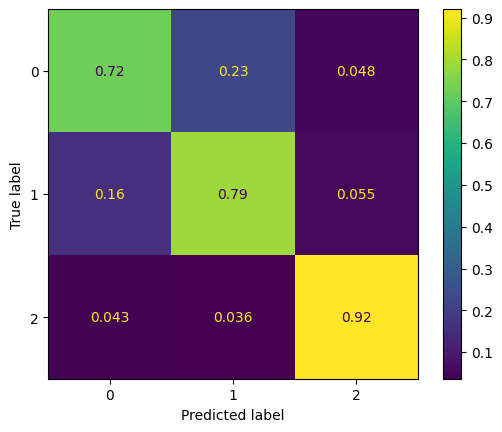

In [ ]:
# conf_mat(best_model_cascade, y_val, y_pred_final)

confusion_mat = confusion_matrix(y_val, y_pred_final, normalize='true')
ConfusionMatrixDisplay(confusion_matrix=confusion_mat).plot()

In [ ]:
len(mask_1_2)

2639

In [ ]:
conf_mat(best_model_cascade, y_val, y_pred_final)

### Reducción de la media a solo las 4 primeras medias